In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
import glob
import os
from scipy import stats
from scipy.spatial import distance_matrix
from scipy.spatial.distance import pdist, squareform
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

### 1. Explore original expression and clinical data

In [2]:
sc.settings.verbosity = 3             
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')


scanpy==1.9.3 anndata==0.9.2 umap==0.5.3 numpy==1.20.3 scipy==1.7.1 pandas==1.3.4 scikit-learn==0.24.2 statsmodels==0.12.2 pynndescent==0.5.10


In [3]:
adata = sc.read_h5ad('COMBAT-CITESeq-EXPRESSION-ATLAS.h5ad')

In [5]:
adata.obs

,Source,GEX_region,cluster,cluster_source,minor_subset,minor_subset_source,major_subset,major_subset_source,cell_type,cell_type_source,...,TimeSinceOnset,QC_ngenes,QC_total_UMI,QC_pct_mitochondrial,QC_scrub_doublet_scores,TCR_clone_count,TCR_clone_proportion,BCR_total_mut_HC,BCR_clonal_abundance_HC,BCR_total_mut_LC
AAACCTGAGAAAGTGG-1-gPlexA1,COVID_SEV,B: TEM/prolif. T/NK cells,NK.CD16hi.1,NK.CD16hi.1_COVID_SEV,NK.CD16hi,NK.CD16hi_COVID_SEV,NK,NK_COVID_SEV,NK,NK_COVID_SEV,...,12.0,1159,2684,1.862891,0.031883,NaN,NaN,NaN,NaN,NaN
AAACCTGAGCGGATCA-1-gPlexA1,COVID_MILD,B: TEM/prolif. T/NK cells,CD8.TEMRA.1,CD8.TEMRA.1_COVID_MILD,CD8.TEMRA,CD8.TEMRA_COVID_MILD,CD8,CD8_COVID_MILD,T,T_COVID_MILD,...,12.0,1348,3162,1.138520,0.041541,54.0,0.015323,NaN,NaN,NaN
AAACCTGAGGACATTA-1-gPlexA1,COVID_HCW_MILD,D: B/Plasma cells,nan,nan_COVID_HCW_MILD,nan,nan_COVID_HCW_MILD,nan,nan_COVID_HCW_MILD,nan,nan_COVID_HCW_MILD,...,17.0,937,2579,0.891819,0.003108,NaN,NaN,0.0,1.0,0.0
AAACCTGAGGCGACAT-1-gPlexA1,COVID_CRIT,C: Monocytes/cDC,ncMono,ncMono_COVID_CRIT,ncMono,ncMono_COVID_CRIT,ncMono,ncMono_COVID_CRIT,MNP,MNP_COVID_CRIT,...,14.0,788,1979,4.194037,0.068193,NaN,NaN,NaN,NaN,NaN
AAACCTGAGGGAACGG-1-gPlexA1,COVID_SEV,C: Monocytes/cDC,cMono.LGALS2.AHNAK,cMono.LGALS2.AHNAK_COVID_SEV,cMono,cMono_COVID_SEV,cMono,cMono_COVID_SEV,MNP,MNP_COVID_SEV,...,6.0,1344,3084,3.728923,0.036749,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTGGCAAAC-1-gPlexK7,HV,C: Monocytes/cDC,cMono.S100A8/9/12hi.HMGB2,cMono.S100A8/9/12hi.HMGB2_HV,cMono,cMono_HV,cMono,cMono_HV,MNP,MNP_HV,...,NaN,1316,3722,3.519613,0.068154,NaN,NaN,NaN,NaN,NaN
TTTGTCAGTTACCGAT-1-gPlexK7,Flu,B: TEM/prolif. T/NK cells,CD8.TEM,CD8.TEM_Flu,CD8.TEM,CD8.TEM_Flu,CD8,CD8_Flu,T,T_Flu,...,11.0,1157,3318,1.476793,0.494080,1.0,0.001151,NaN,NaN,NaN
TTTGTCATCCTCTAGC-1-gPlexK7,COVID_HCW_MILD,B: TEM/prolif. T/NK cells,CD8.TEMRA.mitohi.2,CD8.TEMRA.mitohi.2_COVID_HCW_MILD,CD8.mitohi,CD8.mitohi_COVID_HCW_MILD,CD8,CD8_COVID_HCW_MILD,T,T_COVID_HCW_MILD,...,7.0,502,627,7.017544,0.019165,NaN,NaN,NaN,NaN,NaN
TTTGTCATCGAGGTAG-1-gPlexK7,COVID_SEV,C: Monocytes/cDC,cMono.LGALS2.PSME2.IFITM3hi,cMono.LGALS2.PSME2.IFITM3hi_COVID_SEV,cMono,cMono_COVID_SEV,cMono,cMono_COVID_SEV,MNP,MNP_COVID_SEV,...,3.0,805,1612,2.233251,0.050830,NaN,NaN,NaN,NaN,NaN


Pick only gene expression 

In [4]:
data = adata[:, adata.var['feature_types'] == 'Gene Expression']

Open the clinical file

In [5]:
outcome_data = pd.read_csv('COMBAT_CLINVAR_for_processed.txt', sep = '\t')

In [6]:
merge_data = data.obs.merge(outcome_data, on='scRNASeq_sample_ID', how='left')
merge_data

,Source_x,GEX_region,cluster,cluster_source,minor_subset,minor_subset_source,major_subset,major_subset_source,cell_type,cell_type_source,...,PreExistingDiabetes,PreExistingHypertension,PreExistingImmunocompromised,Smoking,Symptomatic,Requiredvasoactive,Respiratorysupport,SARSCoV2PCR,Outcome,TimeSinceOnset_y
0,COVID_SEV,B: TEM/prolif. T/NK cells,NK.CD16hi.1,NK.CD16hi.1_COVID_SEV,NK.CD16hi,NK.CD16hi_COVID_SEV,NK,NK_COVID_SEV,NK,NK_COVID_SEV,...,0.0,1.0,0.0,0,1.0,1.0,1.0,1,2.0,12.0
1,COVID_MILD,B: TEM/prolif. T/NK cells,CD8.TEMRA.1,CD8.TEMRA.1_COVID_MILD,CD8.TEMRA,CD8.TEMRA_COVID_MILD,CD8,CD8_COVID_MILD,T,T_COVID_MILD,...,0.0,0.0,0.0,0,1.0,0.0,4.0,1,5.0,12.0
2,COVID_HCW_MILD,D: B/Plasma cells,nan,nan_COVID_HCW_MILD,nan,nan_COVID_HCW_MILD,nan,nan_COVID_HCW_MILD,nan,nan_COVID_HCW_MILD,...,NaN,NaN,NaN,0,1.0,NaN,4.0,1,6.0,17.0
3,COVID_CRIT,C: Monocytes/cDC,ncMono,ncMono_COVID_CRIT,ncMono,ncMono_COVID_CRIT,ncMono,ncMono_COVID_CRIT,MNP,MNP_COVID_CRIT,...,0.0,1.0,0.0,0,1.0,1.0,1.0,1,2.0,14.0
4,COVID_SEV,C: Monocytes/cDC,cMono.LGALS2.AHNAK,cMono.LGALS2.AHNAK_COVID_SEV,cMono,cMono_COVID_SEV,cMono,cMono_COVID_SEV,MNP,MNP_COVID_SEV,...,0.0,0.0,0.0,0,1.0,0.0,3.0,1,4.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836143,HV,C: Monocytes/cDC,cMono.S100A8/9/12hi.HMGB2,cMono.S100A8/9/12hi.HMGB2_HV,cMono,cMono_HV,cMono,cMono_HV,MNP,MNP_HV,...,NaN,NaN,NaN,1,NaN,NaN,4.0,0,6.0,NaN
836144,Flu,B: TEM/prolif. T/NK cells,CD8.TEM,CD8.TEM_Flu,CD8.TEM,CD8.TEM_Flu,CD8,CD8_Flu,T,T_Flu,...,0.0,0.0,NaN,0,NaN,1.0,1.0,0,2.0,11.0
836145,COVID_HCW_MILD,B: TEM/prolif. T/NK cells,CD8.TEMRA.mitohi.2,CD8.TEMRA.mitohi.2_COVID_HCW_MILD,CD8.mitohi,CD8.mitohi_COVID_HCW_MILD,CD8,CD8_COVID_HCW_MILD,T,T_COVID_HCW_MILD,...,NaN,NaN,NaN,0,1.0,NaN,4.0,1,6.0,7.0
836146,COVID_SEV,C: Monocytes/cDC,cMono.LGALS2.PSME2.IFITM3hi,cMono.LGALS2.PSME2.IFITM3hi_COVID_SEV,cMono,cMono_COVID_SEV,cMono,cMono_COVID_SEV,MNP,MNP_COVID_SEV,...,1.0,0.0,0.0,1,1.0,0.0,5.0,1,1.0,3.0


In [37]:
outcome_data.isna().sum()

row_number                           0
COMBAT_participant_timepoint_ID      0
COMBAT_ID                            0
RNASeq_sample_ID                   467
scRNASeq_sample_ID                 471
CyTOF_sample_ID                    446
COMBAT_Luminex_sample_ID           284
COMBAT_proteomics_sample_ID        126
COMBAT_antibody_data_ID            273
ATAC_sample_ID                     601
COMBAT_genotype_ID                 335
Source                               0
Age                                  0
Sex                                  0
BMI                                  0
Hospitalstay                       284
Death28                              0
Institute                            0
PreExistingHeartDisease            276
PreExistingLungDisease             276
PreExistingKidneyDisease           212
PreExistingDiabetes                212
PreExistingHypertension            212
PreExistingImmunocompromised       276
Smoking                              0
Symptomatic              

In [19]:
outcome_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611 entries, 0 to 610
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   row_number                       611 non-null    int64  
 1   COMBAT_participant_timepoint_ID  611 non-null    object 
 2   COMBAT_ID                        611 non-null    object 
 3   RNASeq_sample_ID                 144 non-null    object 
 4   scRNASeq_sample_ID               140 non-null    object 
 5   CyTOF_sample_ID                  165 non-null    object 
 6   COMBAT_Luminex_sample_ID         327 non-null    object 
 7   COMBAT_proteomics_sample_ID      485 non-null    object 
 8   COMBAT_antibody_data_ID          338 non-null    object 
 9   ATAC_sample_ID                   10 non-null     object 
 10  COMBAT_genotype_ID               276 non-null    object 
 11  Source                           611 non-null    object 
 12  Age                   

In [ ]:
#preprocess data
columns_to_drop = ['Hospitalstay', 'row_number', 'Symptomatic', 'PreExistingKidneyDisease', 'PreExistingImmunocompromised']
clean_data = outcome_data.drop(columns=columns_to_drop)

In [94]:
clean_data.describe()

,Age,Sex,BMI,Death28,PreExistingHeartDisease,PreExistingLungDisease,PreExistingDiabetes,PreExistingHypertension,Smoking,Requiredvasoactive,Respiratorysupport,SARSCoV2PCR,Outcome,TimeSinceOnset
count,611.000000,611.000000,611.000000,611.000000,335.000000,335.000000,399.000000,399.000000,611.000000,410.000000,459.000000,611.000000,459.000000,579.000000
mean,5.072668,0.500818,4.024550,0.155483,0.101493,0.152239,0.250627,0.358396,0.276596,0.431707,3.302832,0.446809,4.080610,16.618307
std,2.025887,0.500409,1.492402,0.362661,0.302432,0.359790,0.433918,0.480131,0.549598,0.495919,1.355006,0.497570,1.968096,14.775989
min,1.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,4.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,6.000000
50%,5.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,5.000000,12.000000
75%,7.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.500000,1.000000,0.000000,1.000000,4.000000,1.000000,6.000000,23.000000
max,9.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,5.000000,1.000000,6.000000,74.000000


In [123]:
filtered_data = clean_data.dropna(subset=['scRNASeq_sample_ID'])

In [125]:
filtered_data.index = filtered_data['scRNASeq_sample_ID']


In [131]:
filtered_data = filtered_data.drop(columns=['RNASeq_sample_ID','CyTOF_sample_ID', 'COMBAT_Luminex_sample_ID','COMBAT_proteomics_sample_ID','COMBAT_antibody_data_ID', 'ATAC_sample_ID', 'COMBAT_genotype_ID'])
filtered_data

,COMBAT_participant_timepoint_ID,COMBAT_ID,Source,Age,Sex,BMI,Death28,Institute,PreExistingHeartDisease,PreExistingLungDisease,PreExistingDiabetes,PreExistingHypertension,Smoking,Requiredvasoactive,Respiratorysupport,SARSCoV2PCR,Outcome,TimeSinceOnset
scRNASeq_sample_ID,,,,,,,,,,,,,,,,,,
G05061-Ja005E-PBCa,G05061-Ja005,G05061,COVID_HCW_MILD,5.0,1,5,0,Oxford,NaN,NaN,NaN,NaN,0,NaN,4.0,1,6.0,16.0
G05064-Ja005E-PBCa,G05064-Ja005,G05064,COVID_HCW_MILD,5.0,1,5,0,Oxford,NaN,NaN,NaN,NaN,0,NaN,4.0,1,6.0,14.0
G05073-Ja005E-PBCa,G05073-Ja005,G05073,COVID_HCW_MILD,4.0,1,5,0,Oxford,NaN,NaN,NaN,NaN,0,NaN,4.0,1,6.0,18.0
G05077-Ja005E-PBCa,G05077-Ja005,G05077,COVID_HCW_MILD,4.0,0,5,0,Oxford,NaN,NaN,NaN,NaN,0,NaN,4.0,1,6.0,17.0
G05078-Ja005E-PBCa,G05078-Ja005,G05078,COVID_HCW_MILD,3.0,0,5,0,Oxford,NaN,NaN,NaN,NaN,0,NaN,4.0,1,6.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
U00607-Ua005E-PBUa,U00607-Ua005,U00607,Flu,4.0,0,3,0,St_Georges,NaN,NaN,0.0,0.0,0,1.0,1.0,0,2.0,10.0
U00613-Ua005E-PBUa,U00613-Ua005,U00613,Flu,3.0,1,1,0,St_Georges,NaN,NaN,0.0,0.0,0,1.0,1.0,0,2.0,18.0
U00617-Ua005E-PBUa,U00617-Ua005,U00617,Flu,6.0,0,2,0,St_Georges,NaN,NaN,1.0,0.0,1,1.0,1.0,0,2.0,11.0


In [134]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data['Source_encoded'] = label_encoder.fit_transform(filtered_data['Source'])

In [140]:
data['Institute_encoded'] = label_encoder.fit_transform(data['Institute'])

In [138]:
data = data.drop(columns='Source')

In [ ]:
merged_data = data.merge(df2[['scRNASeq_sample_ID', 'новый_столбец']], on='scRNASeq_sample_ID', how='left')

In [106]:
unique_values = filtered_data['scRNASeq_sample_ID'].unique()
print(unique_values)

['N00006-Ja003E-PBGa' 'N00013-Ja005E-PBGa' 'N00017-Ja003E-PBGa'
 'N00037-Ja003E-PBGa' 'N00049-Ja005E-PBGa' 'S00003-Ja003E-PBCa'
 'S00005-Ja003E-PBCa' 'S00005-Ja005E-PBCa' 'S00007-Ja003E-PBCa'
 'S00008-Ja003E-PBCa' 'S00016-Ja001E-PBCa' 'S00020-Ja003E-PBCa'
 'S00028-Ja001E-PBCa' 'S00033-Ja001E-PBCa' 'S00033-Ja003E-PBCa'
 'S00033-Ja005E-PBCa' 'S00034-Ja005E-PBCa' 'S00037-Ja003E-PBCa'
 'S00041-Ja001E-PBCa' 'S00045-Ja001E-PBCa' 'S00045-Ja003E-PBCa'
 'S00045-Ja005E-PBCa' 'S00048-Ja003E-PBCa' 'S00048-Ja005E-PBCa'
 'S00050-Ja001E-PBCa' 'S00053-Ja003E-PBCa' 'S00054-Ja001E-PBCa'
 'S00057-Ja003E-PBCa' 'S00060-Ja005E-PBCa' 'S00066-Ja001E-PBCa'
 'S00067-Ja001E-PBCa' 'S00068-Ja005E-PBCa' 'S00077-Ja005E-PBCa'
 'S00081-Ja001E-PBCa' 'S00081-Ja005E-PBCa' 'S00113-Ja005E-PBCa'
 'S00114-Ja003E-PBCa' 'S00119-Ja003E-PBCa' 'S00134-Ja003E-PBCa'
 'S00142-Ja005E-PBCa' 'U00501-Ua005E-PBUa' 'U00502-Ua005E-PBUa'
 'U00503-Ua005E-PBUa' 'U00504-Ua005E-PBUa' 'U00505-Ua005E-PBUa'
 'U00515-Ua005E-PBUa' 'U00519-Ua005E-PBU

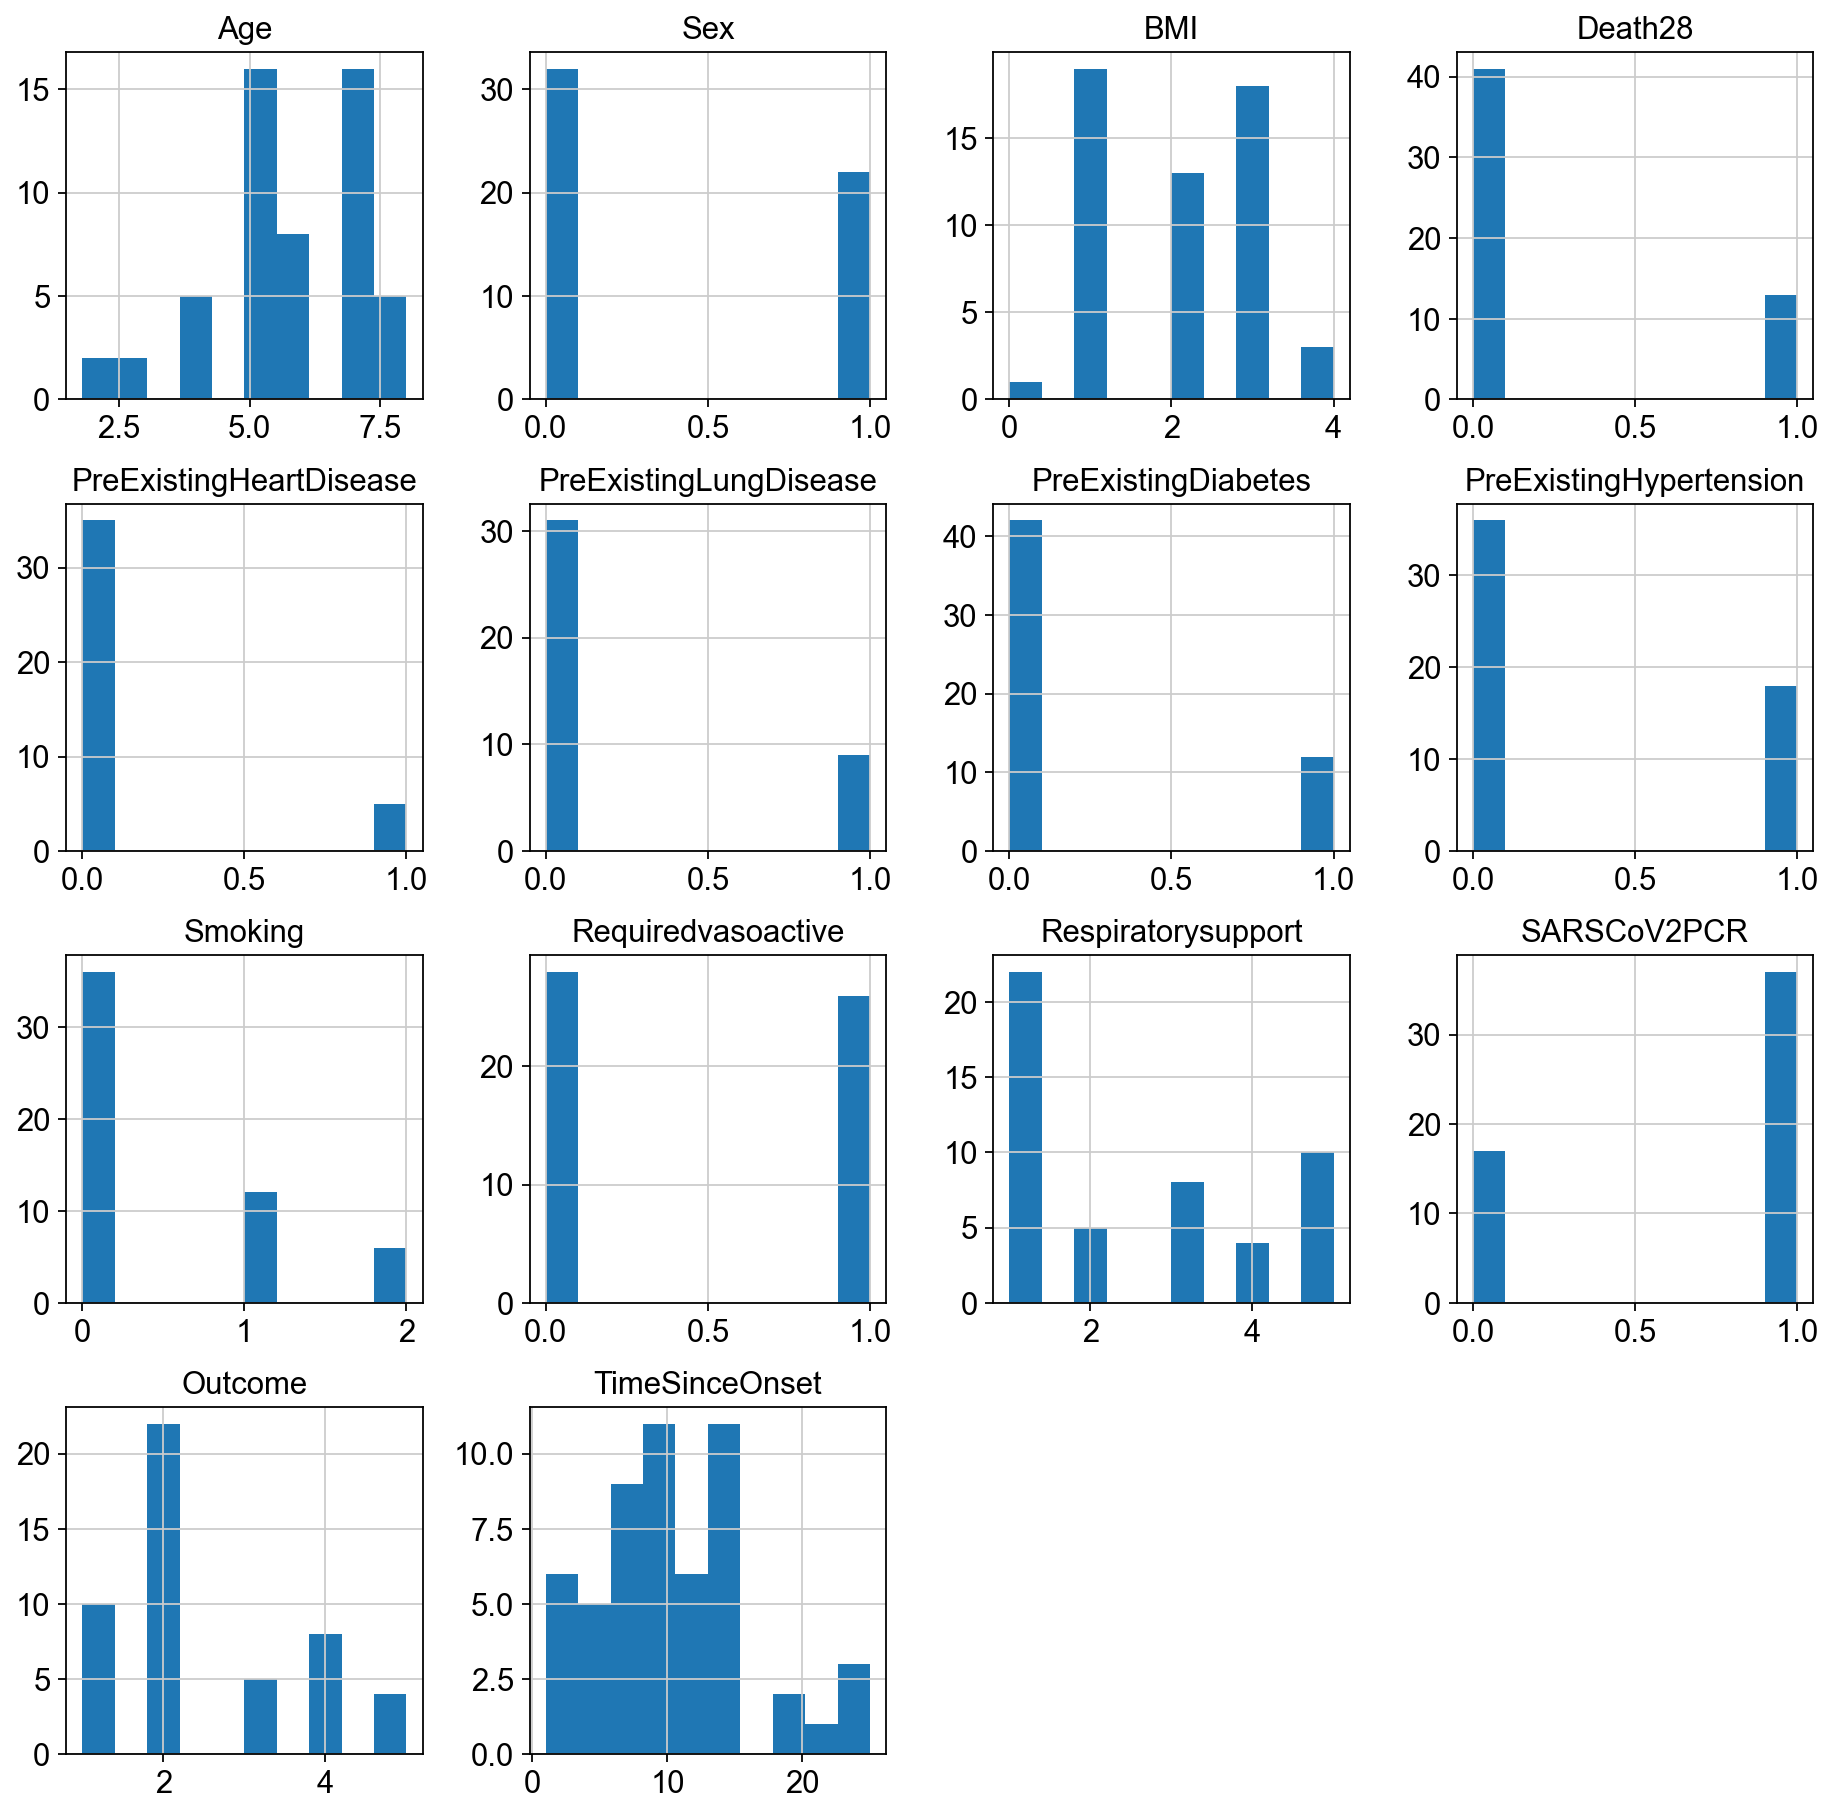

In [99]:
filtered_data.hist(figsize=(14, 14));

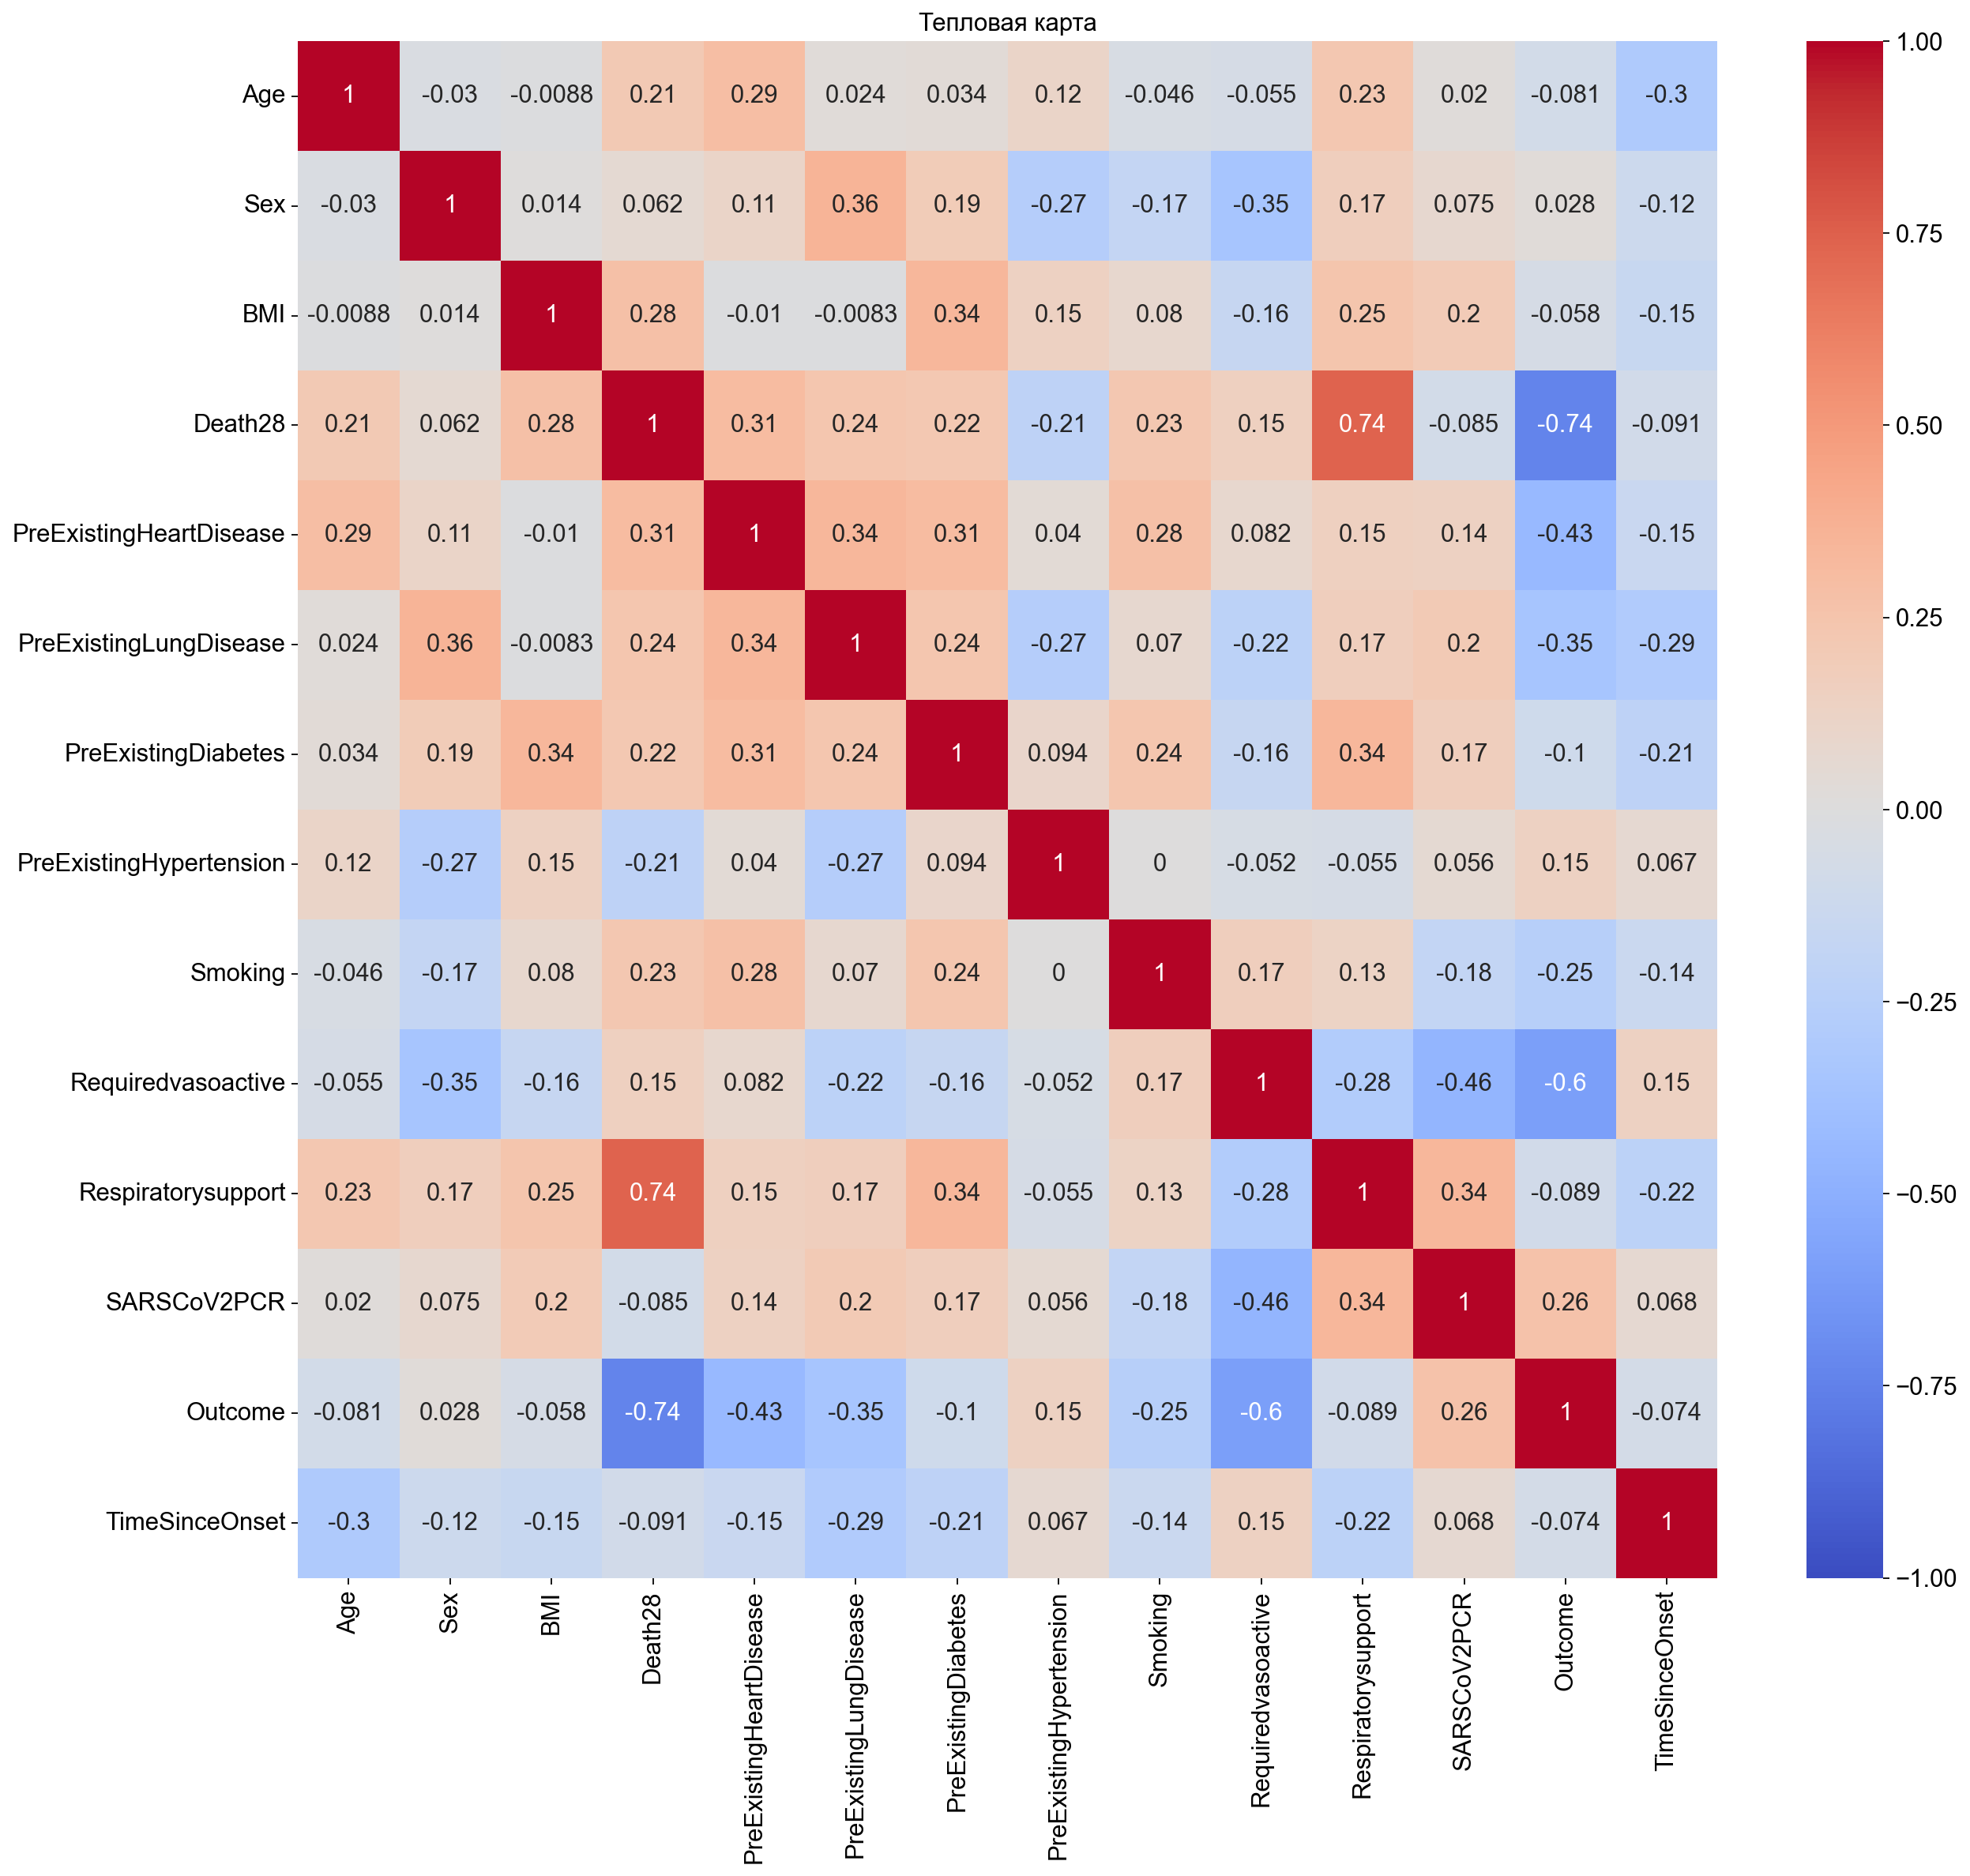

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 16))
sns.heatmap(filtered_data.corr(method='spearman'), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Тепловая карта")
plt.show()


### 2. Create pseudobulk matrix with processed data 

In [32]:
comb_exp = sc.read_h5ad('COMBAT_EXPRESSION_MY')

In [ ]:
sc.pp.neighbors(comb_exp)
sc.tl.leiden(comb_exp)

computing neighbors
    using 'X_pca' with n_pcs = 50


In [46]:
comb_exp.obsm["X_pca"].shape

(836148, 50)

In [201]:
data.isna().sum()

Age                         0
Sex                         0
BMI                         0
Death28                     0
Institute                   0
PreExistingHeartDisease    40
PreExistingLungDisease     40
PreExistingDiabetes        26
PreExistingHypertension    26
Smoking                     0
Requiredvasoactive         23
Respiratorysupport         25
SARSCoV2PCR                 0
Outcome                    25
TimeSinceOnset             10
Source_encoded              0
Institute_encoded           0
dtype: int64

In [50]:
numeric_data = comb_exp.X

In [61]:
donors = {}
for donor_id in range(1, 11):
    don = comb_exp.X[comb_exp.obs['donor_id'] == donor_id]
    donors[donor_id] = don.mean(axis=0)

In [73]:
adata_donors = pd.DataFrame(donors).T

In [108]:
def calculate_distance_matrix(data, ID):
    """
    Computes a matrix of pairwise distances between donors based on data from X_pca.
    
    Parameters:
        data (AnnData): AnnData object containing the X_pca data matrix.
        ID (str): The ID of the column in data.obs by which donors will be grouped.
    
    Returns:
        pd.DataFrame: Matrix of pairwise distances between donors.
    """
    donors = {}
    unique_categories = data.obs[ID].unique()
    
    for category in unique_categories:
        don = data.obsm['X_pca'][data.obs[ID] == category]
        donors[category] = don.mean(axis=0)
    
    data_donors = pd.DataFrame(donors).T
    distances = pdist(data_donors.values)
    distance_matrix = squareform(distances)
    distance_df = pd.DataFrame(distance_matrix, index=data_donors.index, columns=data_donors.index)
    
    return distance_df, data_donors

distance_matrix, data_donors = calculate_distance_matrix(comb_exp, 'scRNASeq_sample_ID')

print(distance_matrix)

                    S00109-Ja001E-PBCa  S00112-Ja003E-PBCa  \
S00109-Ja001E-PBCa            0.000000            4.585622   
S00112-Ja003E-PBCa            4.585622            0.000000   
G05153-Ja005E-PBCa            5.198242            4.314982   
S00005-Ja005E-PBCa            7.257566            5.443444   
S00061-Ja003E-PBCa            3.961200            6.021301   
...                                ...                 ...   
S00065-Ja003E-PBCa            4.906554            4.799295   
S00048-Ja003E-PBCa            4.867388            3.053273   
G05112-Ja005E-PBCa            5.124875            6.741180   
N00038-Ja001E-PBGa            5.112689            5.586455   
U00501-Ua005E-PBUa            6.756444            4.647621   

                    G05153-Ja005E-PBCa  S00005-Ja005E-PBCa  \
S00109-Ja001E-PBCa            5.198242            7.257566   
S00112-Ja003E-PBCa            4.314982            5.443444   
G05153-Ja005E-PBCa            0.000000            4.311739   
S00005-

In [181]:
distance_matrix = distance_matrix.drop(columns= ['G05092-Ja005E-PBCa', 'S00030-Ja003E-PBCa'])

In [182]:
rows_to_drop = ['G05092-Ja005E-PBCa', 'S00030-Ja003E-PBCa']
distance_matrix = distance_matrix.drop(rows_to_drop)

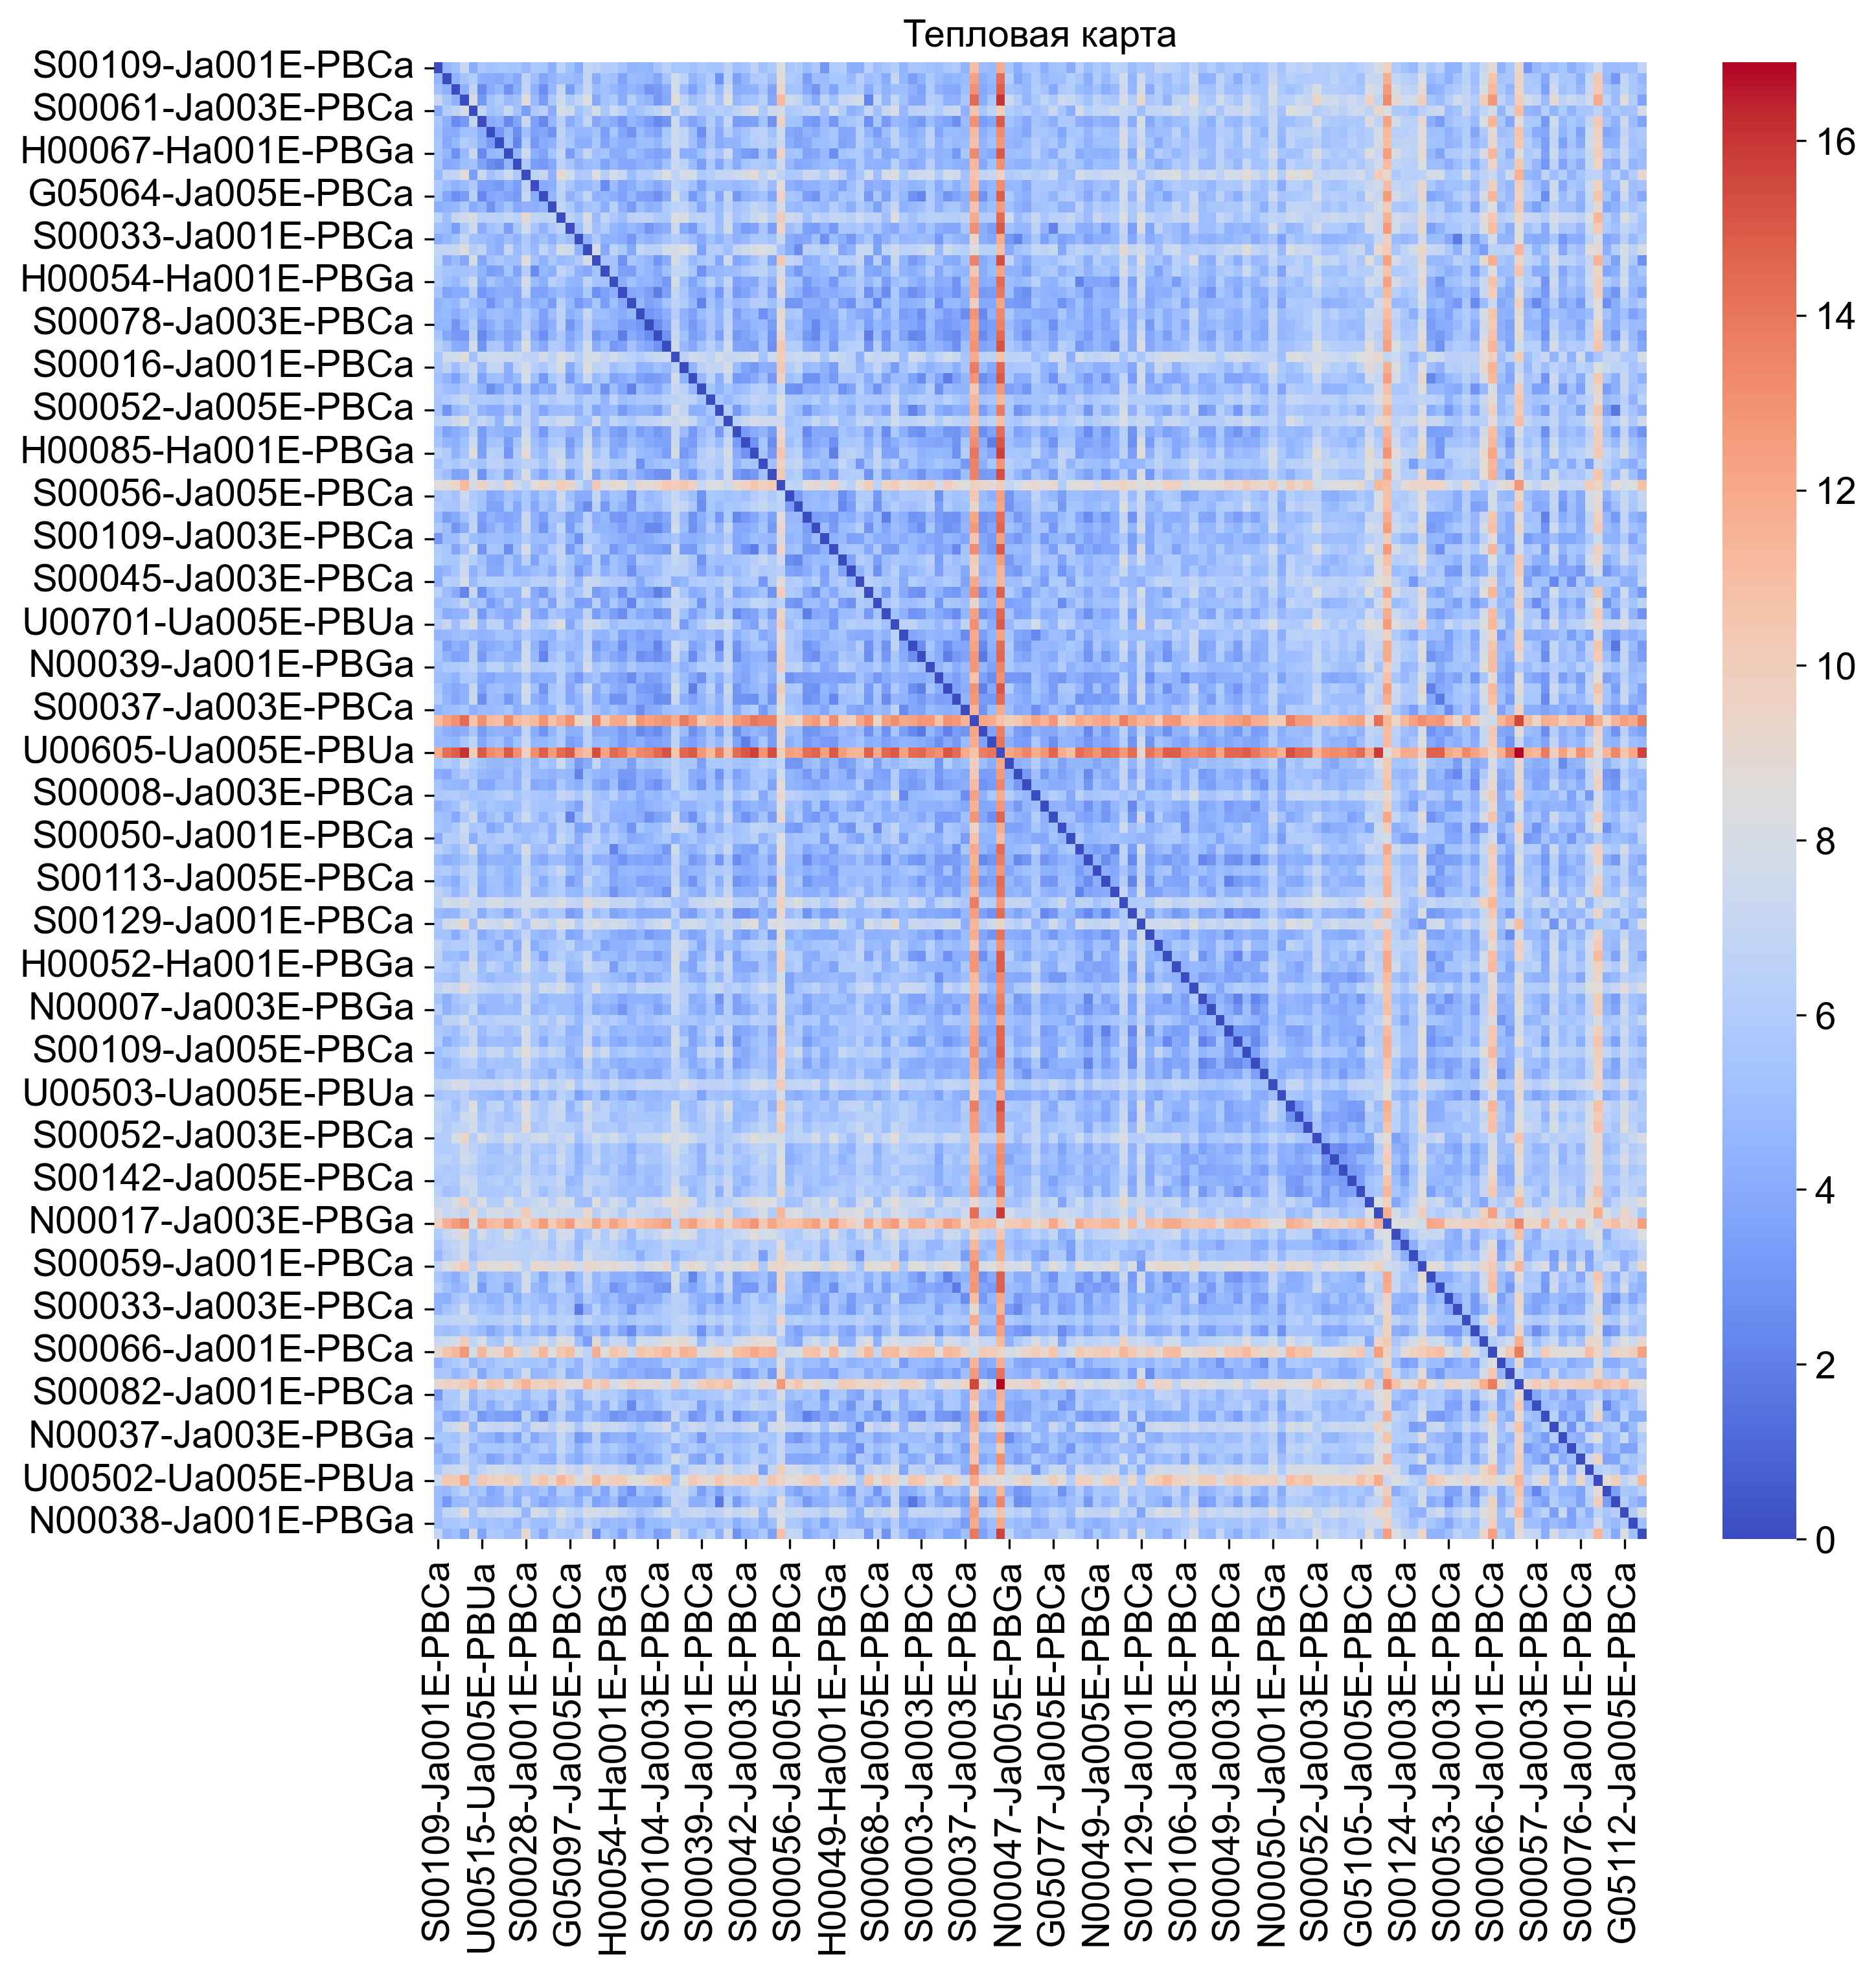

In [184]:
plt.figure(figsize=(10, 10), dpi=150)
sns.heatmap(distance_matrix, cmap='coolwarm')
plt.title("Тепловая карта")
plt.show()

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\Users\Admin\anaconda3\lib\site-packages\seaborn\matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


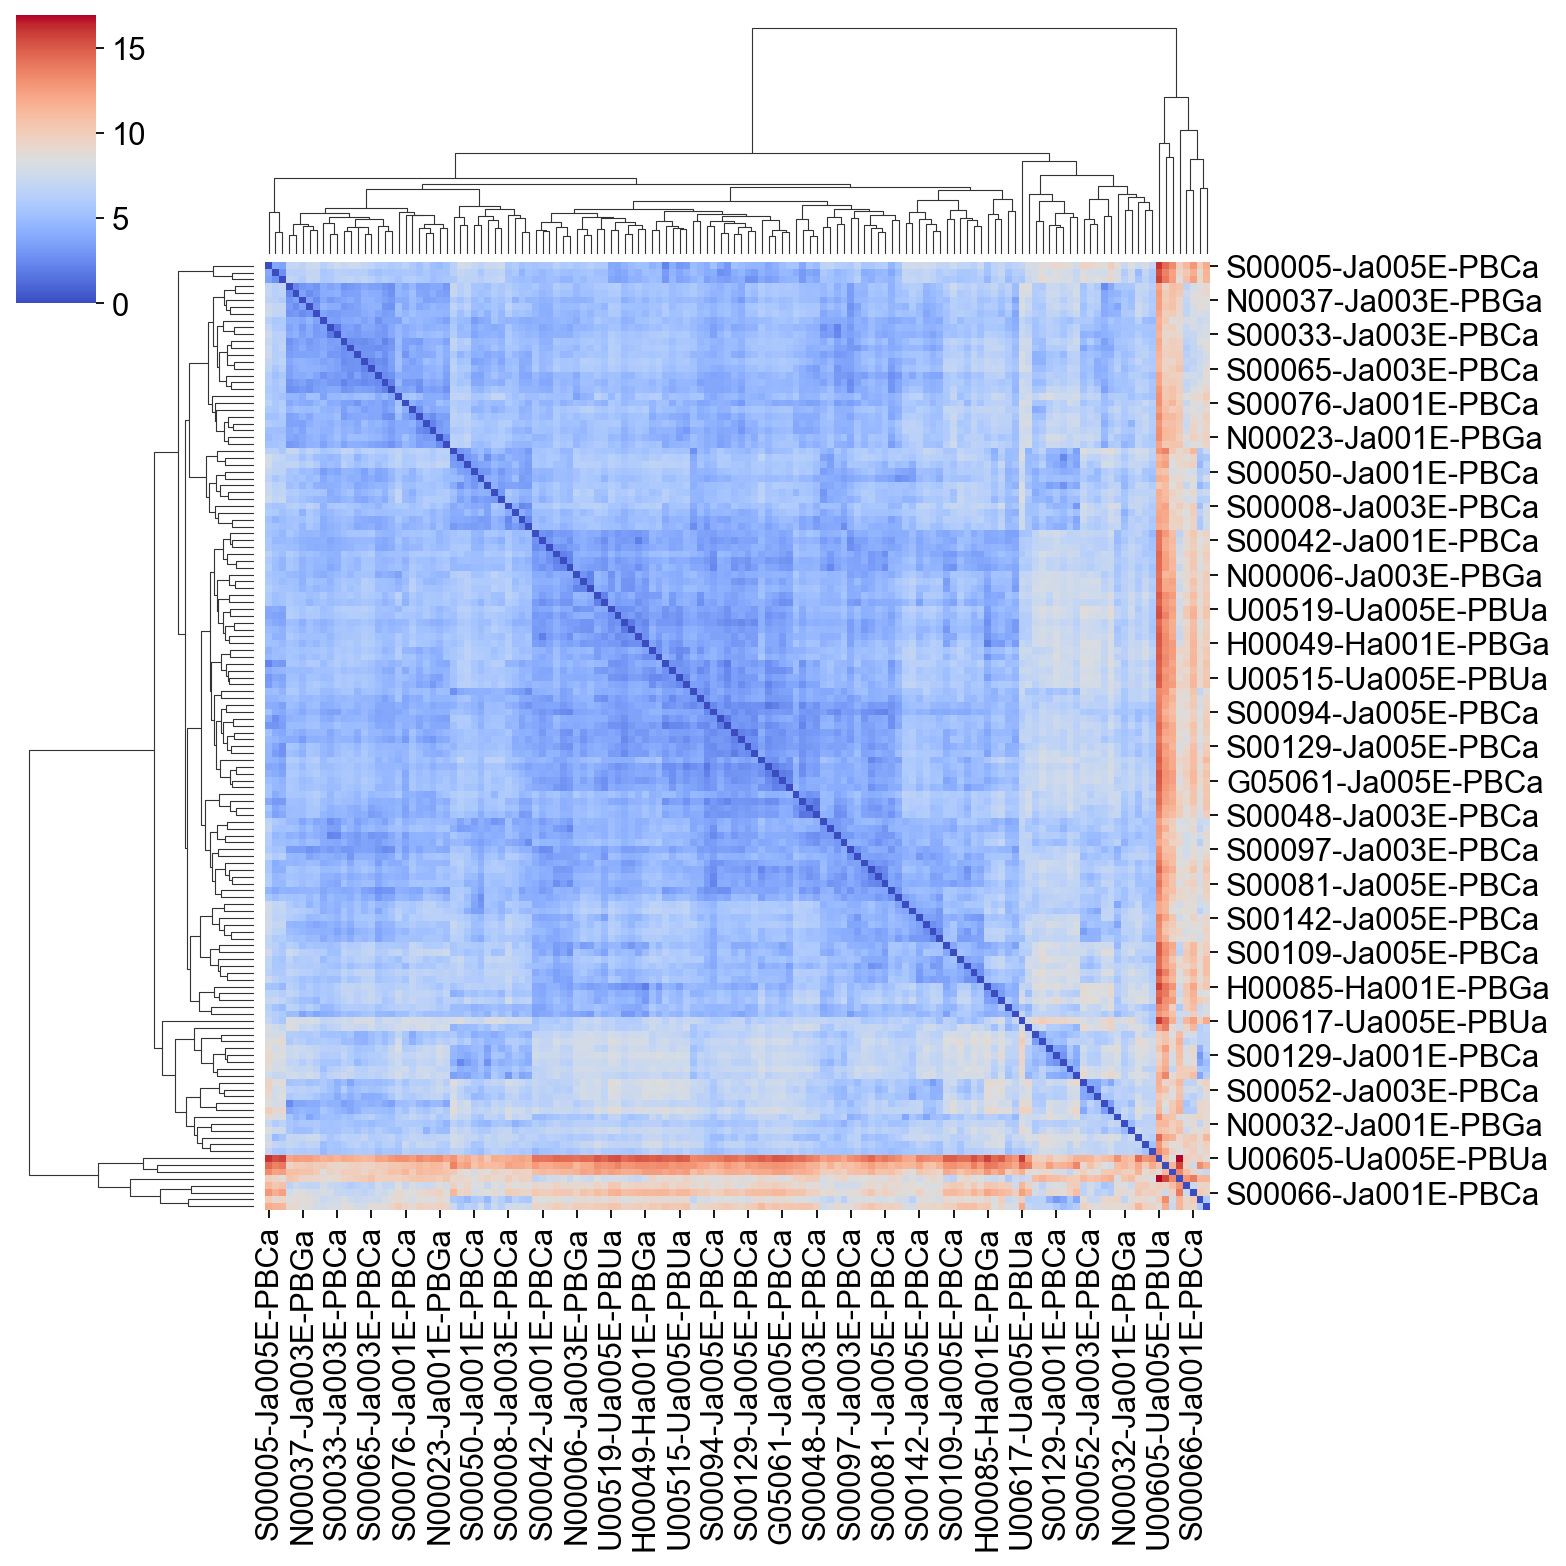

In [185]:
sns.clustermap(distance_matrix, cmap='coolwarm')

Метки кластеров для строк: [3, 18, 137, 41, 46, 128, 40, 65, 96, 16, 116, 50, 71, 47, 125, 133, 118, 22, 30, 82, 130, 13, 6, 7, 9, 11, 19, 37, 48, 111, 72, 121, 129, 0, 124, 68, 136, 53, 60, 122, 63, 81, 90, 76, 79, 77, 20, 73, 15, 70, 26, 38, 59, 114, 35, 45, 2, 8, 49, 43, 5, 12, 23, 24, 62, 74, 21, 25, 42, 126, 34, 51, 83, 55, 58, 29, 113, 1, 54, 32, 134, 44, 69, 66, 115, 57, 85, 88, 91, 87, 93, 67, 94, 89, 110, 104, 102, 101, 103, 84, 92, 99, 105, 97, 98, 36, 28, 52, 56, 75, 107, 78, 4, 10, 135, 80, 127, 27, 131, 106, 100, 109, 17, 119, 86, 31, 33, 14, 95, 117, 64, 61, 108, 123, 39, 120, 112, 132]
Метки кластеров для столбцов: [3, 18, 137, 41, 46, 128, 40, 65, 96, 16, 116, 50, 71, 47, 125, 133, 118, 22, 30, 82, 130, 13, 6, 7, 9, 11, 19, 37, 48, 111, 72, 121, 129, 0, 124, 68, 136, 53, 60, 122, 63, 81, 90, 76, 79, 77, 20, 73, 15, 70, 26, 38, 59, 114, 35, 45, 2, 8, 49, 43, 5, 12, 23, 24, 62, 74, 21, 25, 42, 126, 34, 51, 83, 55, 58, 29, 113, 1, 54, 32, 134, 44, 69, 66, 115, 57, 85, 88, 

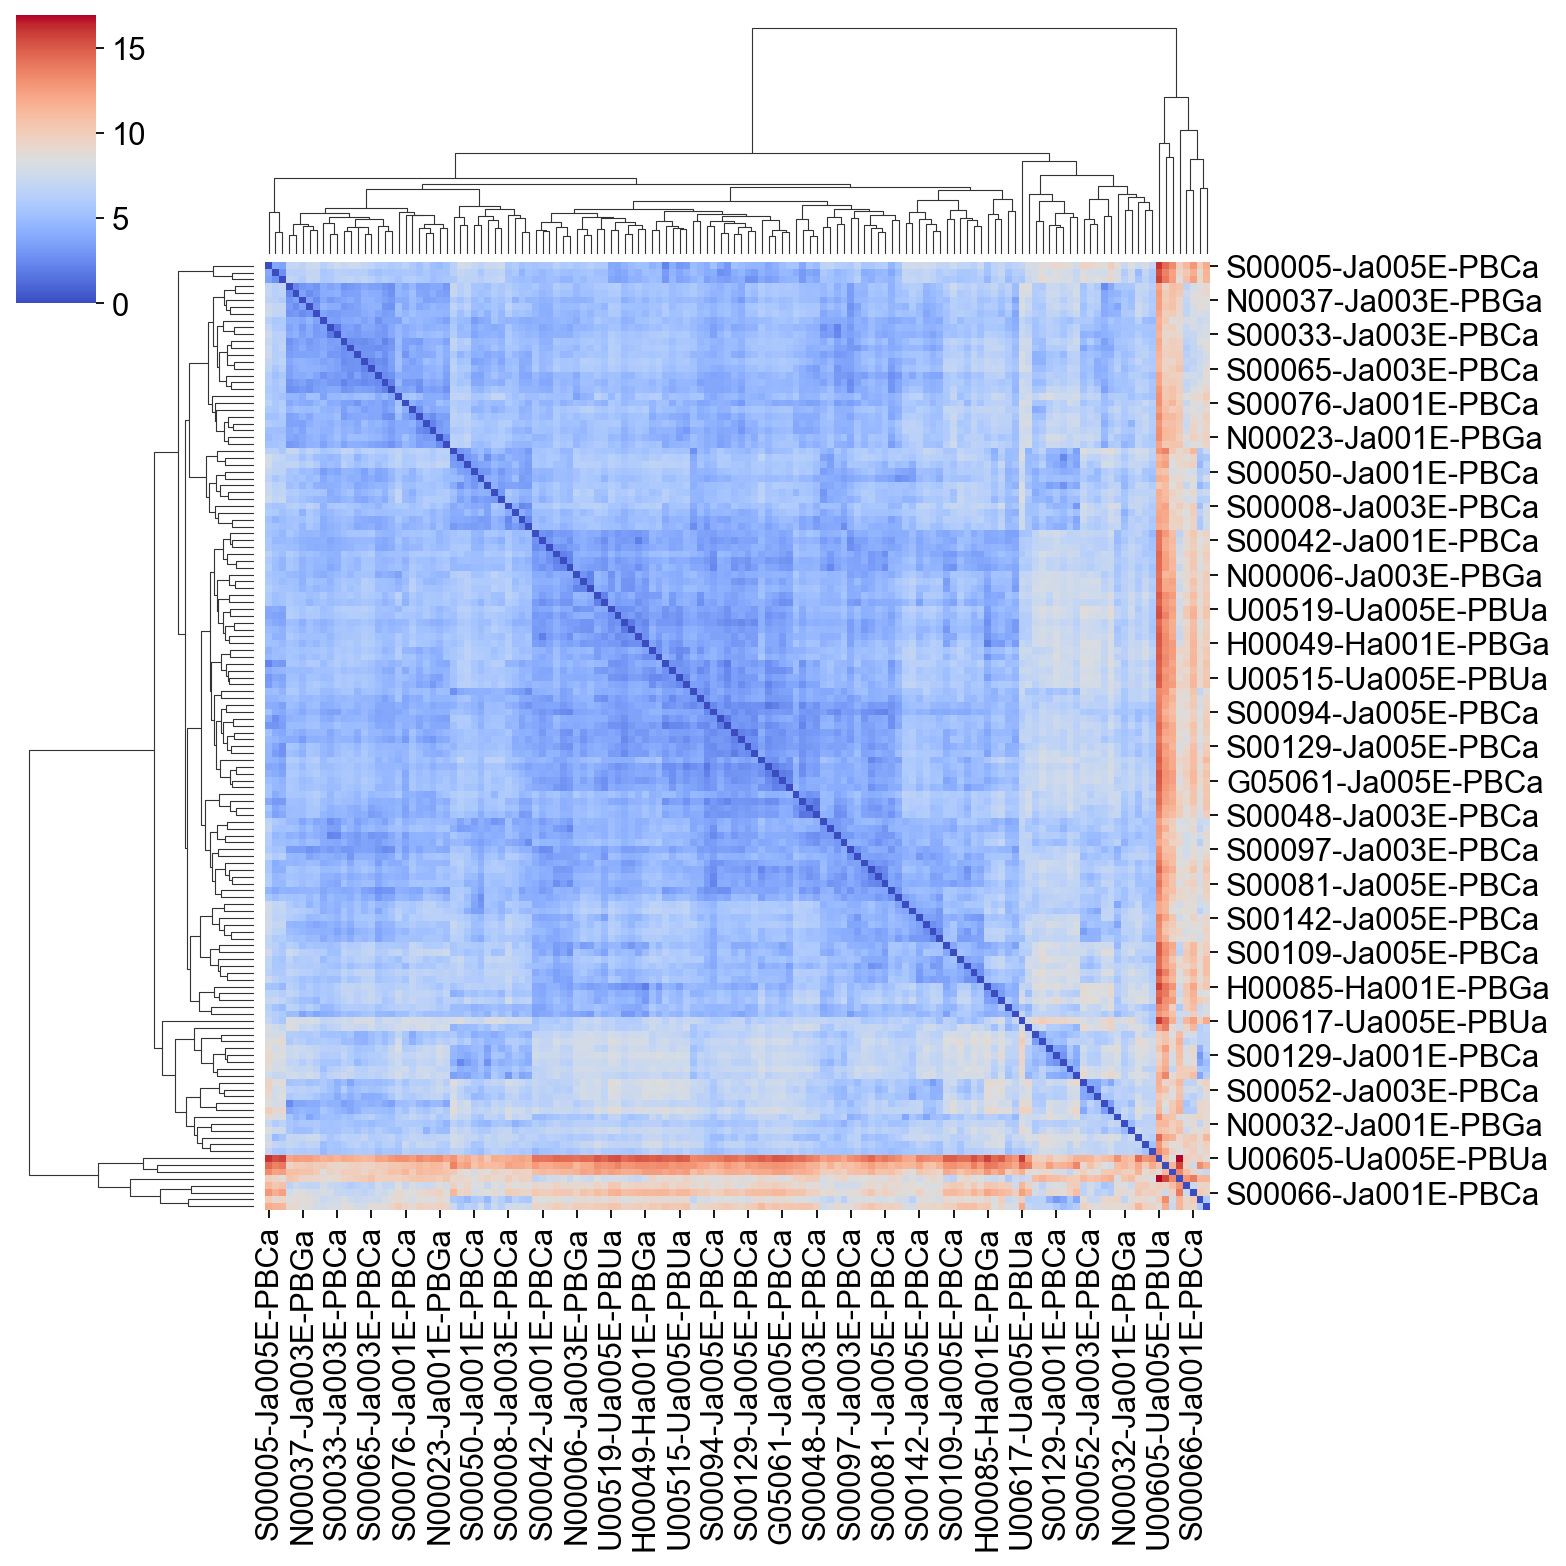

In [187]:
clustergrid = sns.clustermap(distance_matrix, cmap='coolwarm')

#Get cluster labels for rows and columns
row_cluster_labels = clustergrid.dendrogram_row.reordered_ind
col_cluster_labels = clustergrid.dendrogram_col.reordered_ind

# Print the cluster labels
print("Метки кластеров для строк:", row_cluster_labels)
print("Метки кластеров для столбцов:", col_cluster_labels)

In [188]:
last_8_rows_indices = clustergrid.dendrogram_row.reordered_ind[-8:]
last_8_columns_indices = clustergrid.dendrogram_col.reordered_ind[-8:]

#Select the last 8 rows and columns
last_8_rows_data = distance_matrix.iloc[last_8_rows_indices]
last_8_rows_and_columns_data = distance_matrix.iloc[last_8_rows_indices, last_8_columns_indices]

In [189]:
last_8_rows_data 

,S00109-Ja001E-PBCa,S00112-Ja003E-PBCa,G05153-Ja005E-PBCa,S00005-Ja005E-PBCa,S00061-Ja003E-PBCa,U00515-Ua005E-PBUa,S00056-Ja003E-PBCa,N00027-Ja001E-PBGa,H00067-Ha001E-PBGa,U00505-Ua005E-PBUa,...,N00037-Ja003E-PBGa,S00002-Ja001E-PBCa,S00076-Ja001E-PBCa,S00072-Ja001E-PBCa,U00502-Ua005E-PBUa,S00065-Ja003E-PBCa,S00048-Ja003E-PBCa,G05112-Ja005E-PBCa,N00038-Ja001E-PBGa,U00501-Ua005E-PBUa
U00605-Ua005E-PBUa,11.873627,14.239004,14.794192,16.039902,10.084730,14.913103,13.301185,12.797933,15.004104,13.114495,...,12.392130,10.347547,13.004742,11.596703,8.702282,11.412676,13.447547,10.582699,12.113607,15.692651
N00040-Ja001E-PBGa,11.056472,12.388052,13.047646,14.410033,10.674058,13.046501,11.189285,10.776285,13.286940,11.259392,...,10.032717,11.022862,10.633581,13.423550,11.854855,9.459936,11.505007,12.415579,11.964365,13.861103
N00017-Ja003E-PBGa,9.727045,11.643050,12.537291,13.259359,8.263007,12.213598,11.211706,10.937266,12.511873,11.022689,...,10.650341,8.428928,11.383057,8.749318,7.247673,9.897462,10.973450,9.126464,9.754432,12.433930
U00504-Ua005E-PBUa,9.101351,9.660773,9.487364,9.891463,11.056478,8.813989,10.506219,10.397117,8.610527,10.332022,...,9.409662,9.618819,10.054843,9.991796,11.369045,10.648147,9.911809,11.080375,9.052976,8.665115
U00607-Ua005E-PBUa,8.390873,8.717834,9.363662,11.274092,7.883761,9.631702,7.550457,7.205040,9.493661,7.558668,...,6.909367,7.065164,7.078660,10.038108,9.441299,6.435069,8.744156,7.999959,8.396336,10.759110
S00066-Ja001E-PBCa,8.929551,10.522906,11.151798,12.757537,7.812916,11.298366,8.891098,9.248875,11.394879,9.551118,...,8.634773,8.399711,8.661005,10.948506,9.444817,7.077539,9.682669,9.217231,9.855384,12.341487
S00059-Ja001E-PBCa,6.902827,8.308695,9.040278,10.058680,6.367773,9.034518,8.625088,8.680156,9.169919,8.367676,...,8.588412,4.700399,8.349003,3.888143,5.928776,7.509502,7.731145,4.351566,6.525979,9.338882
U00502-Ua005E-PBUa,7.349336,10.371915,10.280771,11.813765,6.615894,10.234475,9.703971,9.566342,9.951880,9.490825,...,8.412473,5.790720,9.428537,6.147651,0.000000,8.716538,9.872659,6.689166,7.677029,11.379771


In [192]:
last_8_rows_indices = clustergrid.dendrogram_row.reordered_ind[-8:]

#  Get the row names from the second dataframe using the resulting indexes
matching_rows = data.index.isin(distance_matrix.index[last_8_rows_indices])

# Select rows from the second dataframe that match the found indexes
matching_rows_data = data[matching_rows]
matching_rows_data

,Age,Sex,BMI,Death28,Institute,PreExistingHeartDisease,PreExistingLungDisease,PreExistingDiabetes,PreExistingHypertension,Smoking,Requiredvasoactive,Respiratorysupport,SARSCoV2PCR,Outcome,TimeSinceOnset,Source_encoded,Institute_encoded
scRNASeq_sample_ID,,,,,,,,,,,,,,,,,
N00017-Ja003E-PBGa,5.0,0,4,1,Oxford,0.0,0.0,0.0,0.0,1,1.0,NaN,0,NaN,7.0,7,0
N00040-Ja001E-PBGa,8.0,1,5,1,Oxford,1.0,0.0,0.0,1.0,0,0.0,NaN,0,NaN,1.0,7,0
S00059-Ja001E-PBCa,3.0,0,5,0,Oxford,0.0,0.0,0.0,0.0,0,0.0,4.0,1,5.0,6.0,3,0
S00066-Ja001E-PBCa,7.0,0,2,1,Oxford,0.0,1.0,0.0,0.0,0,1.0,5.0,1,1.0,10.0,4,0
U00502-Ua005E-PBUa,8.0,0,1,0,St_Georges,NaN,NaN,0.0,1.0,0,1.0,1.0,0,2.0,3.0,5,1
U00504-Ua005E-PBUa,7.0,0,1,0,St_Georges,NaN,NaN,0.0,0.0,0,1.0,1.0,0,2.0,4.0,5,1
U00605-Ua005E-PBUa,5.0,0,2,0,St_Georges,NaN,NaN,0.0,0.0,2,1.0,1.0,0,2.0,1.0,5,1
U00607-Ua005E-PBUa,4.0,0,3,0,St_Georges,NaN,NaN,0.0,0.0,0,1.0,1.0,0,2.0,10.0,5,1


<Figure size 16000x14400 with 0 Axes>

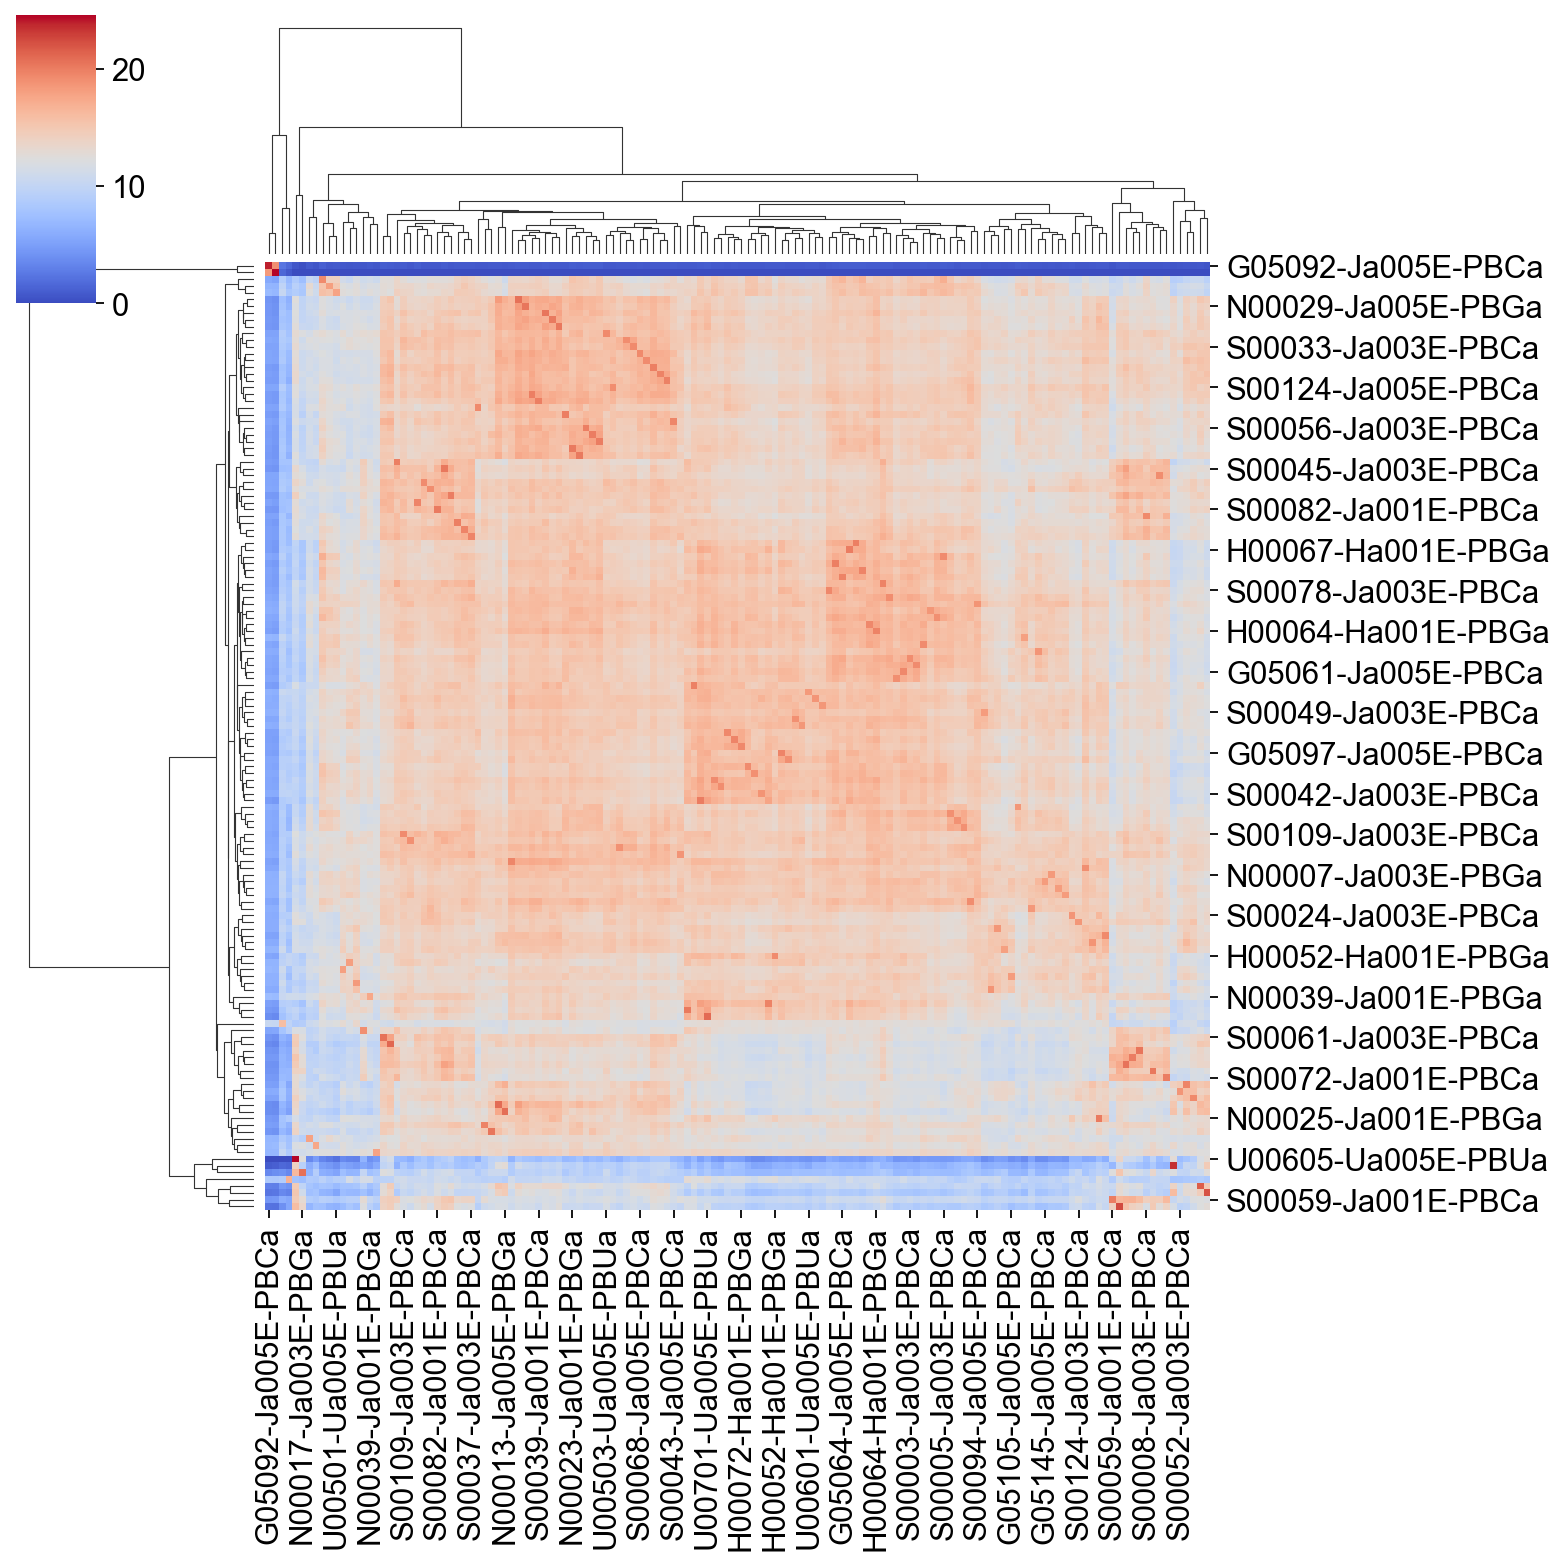

In [122]:
similarity_matrix = np.max(distance_matrix) - distance_matrix

# build clustermap
plt.figure(figsize=(200, 180))
sns.clustermap(similarity_matrix, cmap='coolwarm', annot=False)

plt.show()

In [113]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

C:\Users\Admin\AppData\Local\Temp/ipykernel_30096/3322473043.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='ward')


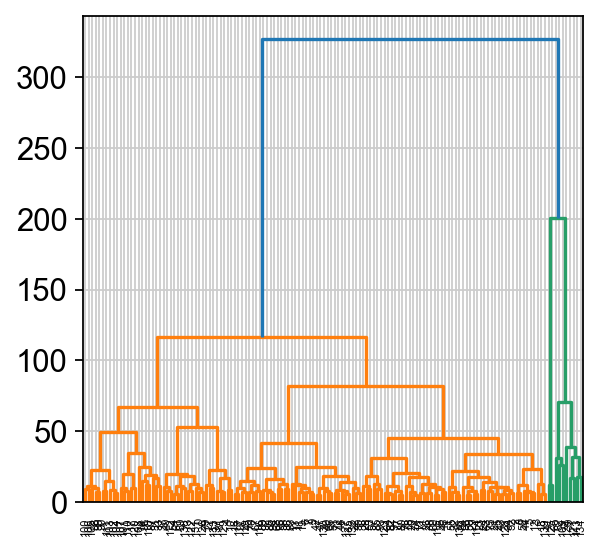

In [114]:
linkage_matrix = linkage(distance_matrix, method='ward')

dendrogram(linkage_matrix)

plt.show()

In [142]:
distance_matrix

,S00109-Ja001E-PBCa,S00112-Ja003E-PBCa,G05153-Ja005E-PBCa,S00005-Ja005E-PBCa,S00061-Ja003E-PBCa,U00515-Ua005E-PBUa,S00056-Ja003E-PBCa,N00027-Ja001E-PBGa,H00067-Ha001E-PBGa,U00505-Ua005E-PBUa,...,N00037-Ja003E-PBGa,S00002-Ja001E-PBCa,S00076-Ja001E-PBCa,S00072-Ja001E-PBCa,U00502-Ua005E-PBUa,S00065-Ja003E-PBCa,S00048-Ja003E-PBCa,G05112-Ja005E-PBCa,N00038-Ja001E-PBGa,U00501-Ua005E-PBUa
S00109-Ja001E-PBCa,0.000000,4.585622,5.198242,7.257566,3.961200,5.599148,5.238873,5.509578,5.456977,5.439730,...,5.497564,4.176182,4.891935,5.869602,7.349336,4.906554,4.867388,5.124875,5.112689,6.756444
S00112-Ja003E-PBCa,4.585622,0.000000,4.314982,5.443444,6.021301,4.210788,4.024605,3.876625,4.585184,3.876861,...,5.536017,5.730390,4.156811,7.080562,10.371915,4.799295,3.053273,6.741180,5.586455,4.647621
G05153-Ja005E-PBCa,5.198242,4.314982,0.000000,4.311739,6.717991,2.482291,3.959859,4.737184,2.710478,4.096786,...,5.247296,5.835532,4.622398,7.226733,10.280771,5.677479,4.874929,7.034492,5.643195,5.122362
S00005-Ja005E-PBCa,7.257566,5.443444,4.311739,0.000000,7.954016,3.067113,5.228327,6.108954,4.813738,5.111448,...,6.641261,7.321498,6.571234,7.624031,11.813765,6.690007,4.851210,8.717995,6.028929,3.610321
S00061-Ja003E-PBCa,3.961200,6.021301,6.717991,7.954016,0.000000,6.801036,5.197383,5.556476,7.233719,5.335020,...,5.914528,4.450514,5.664005,5.586617,6.615894,4.967804,5.682740,5.212774,5.338690,7.947716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S00065-Ja003E-PBCa,4.906554,4.799295,5.677479,6.690007,4.967804,5.517162,3.732036,4.402029,6.157838,4.454445,...,4.484342,4.292000,3.640730,6.716369,8.716538,0.000000,3.426708,5.571649,5.335700,6.352174
S00048-Ja003E-PBCa,4.867388,3.053273,4.874929,4.851210,5.682740,4.305470,4.070252,4.330663,5.319243,3.999873,...,4.893813,5.039455,3.668623,6.220415,9.872659,3.426708,0.000000,6.204544,4.769311,3.939374
G05112-Ja005E-PBCa,5.124875,6.741180,7.034492,8.717995,5.212774,7.446118,6.824228,7.280602,7.520964,7.021792,...,7.237495,3.548280,6.013346,4.245995,6.689166,5.571649,6.204544,0.000000,5.957097,8.197677
N00038-Ja001E-PBGa,5.112689,5.586455,5.643195,6.028929,5.338690,4.930342,5.495193,5.188520,5.456441,4.549787,...,4.366508,3.603818,5.388291,5.201343,7.677029,5.335700,4.769311,5.957097,0.000000,5.181946


### 3. Explore leiden clusterization 

In [12]:
clin_data = pd.read_csv('clin_table.csv', sep='\t')
clin_data

,scRNASeq_sample_ID,Age,Sex,BMI,Death28,Institute,PreExistingHeartDisease,PreExistingLungDisease,PreExistingDiabetes,PreExistingHypertension,Smoking,Requiredvasoactive,Respiratorysupport,SARSCoV2PCR,Outcome,TimeSinceOnset,Source_encoded,Institute_encoded
0,G05061-Ja005E-PBCa,5.0,1,5,0,Oxford,NaN,NaN,NaN,NaN,0,NaN,4.0,1,6.0,16.0,1,0
1,G05064-Ja005E-PBCa,5.0,1,5,0,Oxford,NaN,NaN,NaN,NaN,0,NaN,4.0,1,6.0,14.0,1,0
2,G05073-Ja005E-PBCa,4.0,1,5,0,Oxford,NaN,NaN,NaN,NaN,0,NaN,4.0,1,6.0,18.0,1,0
3,G05077-Ja005E-PBCa,4.0,0,5,0,Oxford,NaN,NaN,NaN,NaN,0,NaN,4.0,1,6.0,17.0,1,0
4,G05078-Ja005E-PBCa,3.0,0,5,0,Oxford,NaN,NaN,NaN,NaN,0,NaN,4.0,1,6.0,10.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,U00607-Ua005E-PBUa,4.0,0,3,0,St_Georges,NaN,NaN,0.0,0.0,0,1.0,1.0,0,2.0,10.0,5,1
136,U00613-Ua005E-PBUa,3.0,1,1,0,St_Georges,NaN,NaN,0.0,0.0,0,1.0,1.0,0,2.0,18.0,5,1
137,U00617-Ua005E-PBUa,6.0,0,2,0,St_Georges,NaN,NaN,1.0,0.0,1,1.0,1.0,0,2.0,11.0,5,1
138,U00619-Ua005E-PBUa,4.0,0,1,1,St_Georges,NaN,NaN,0.0,0.0,0,1.0,5.0,0,1.0,25.0,5,1


In [16]:
patients_list = ['S00056-Ja003E-PBCa', 'N00027-Ja001E-PBGa', 'U00505-Ua005E-PBUa',
       'N00023-Ja001E-PBGa', 'S00043-Ja005E-PBCa', 'S00033-Ja001E-PBCa',
       'N00018-Ja003E-PBGa', 'N00024-Ja001E-PBGa', 'S00034-Ja005E-PBCa',
       'S00039-Ja001E-PBCa', 'N00028-Ja001E-PBGa', 'U00607-Ua005E-PBUa',
       'S00056-Ja005E-PBCa', 'N00033-Ja001E-PBGa', 'N00029-Ja005E-PBGa',
       'S00041-Ja001E-PBCa', 'S00068-Ja005E-PBCa', 'S00097-Ja003E-PBCa',
       'N00040-Ja001E-PBGa', 'N00047-Ja005E-PBGa', 'S00033-Ja005E-PBCa',
       'S00134-Ja003E-PBCa', 'N00012-Ja003E-PBGa', 'U00503-Ua005E-PBUa',
       'S00052-Ja003E-PBCa', 'S00069-Ja005E-PBCa', 'S00054-Ja001E-PBCa',
       'S00033-Ja003E-PBCa', 'S00124-Ja005E-PBCa', 'N00013-Ja005E-PBGa',
       'S00066-Ja001E-PBCa', 'S00057-Ja003E-PBCa', 'N00037-Ja003E-PBGa',
       'S00076-Ja001E-PBCa', 'S00065-Ja003E-PBCa']

selected_rows0 = clin_data.loc[clin_data['scRNASeq_sample_ID'].isin(patients_list)]

selected_rows0

,scRNASeq_sample_ID,Age,Sex,BMI,Death28,Institute,PreExistingHeartDisease,PreExistingLungDisease,PreExistingDiabetes,PreExistingHypertension,Smoking,Requiredvasoactive,Respiratorysupport,SARSCoV2PCR,Outcome,TimeSinceOnset,Source_encoded,Institute_encoded
25,N00012-Ja003E-PBGa,7.0,1,5,1,Oxford,0.0,0.0,0.0,0.0,1,1.0,NaN,0,NaN,6.0,7,0
26,N00013-Ja005E-PBGa,8.0,1,1,0,Oxford,0.0,0.0,0.0,1.0,0,0.0,NaN,0,NaN,4.0,7,0
28,N00018-Ja003E-PBGa,7.0,0,5,0,Oxford,NaN,NaN,NaN,NaN,1,0.0,NaN,0,NaN,9.0,7,0
30,N00023-Ja001E-PBGa,7.0,0,5,0,Oxford,0.0,0.0,1.0,1.0,0,0.0,NaN,0,NaN,8.0,7,0
32,N00024-Ja001E-PBGa,7.0,0,5,0,Oxford,0.0,1.0,0.0,0.0,1,0.0,NaN,0,NaN,0.0,7,0
34,N00027-Ja001E-PBGa,6.0,1,5,0,Oxford,NaN,NaN,NaN,NaN,0,1.0,NaN,0,NaN,9.0,7,0
35,N00028-Ja001E-PBGa,4.0,1,5,0,Oxford,0.0,0.0,0.0,0.0,0,0.0,NaN,0,NaN,0.0,7,0
37,N00029-Ja005E-PBGa,6.0,0,5,0,Oxford,0.0,0.0,0.0,1.0,0,1.0,NaN,0,NaN,4.0,7,0
39,N00033-Ja001E-PBGa,1.8,0,5,0,Oxford,0.0,0.0,0.0,0.0,0,0.0,NaN,0,NaN,0.0,7,0
40,N00037-Ja003E-PBGa,7.0,1,3,1,Oxford,0.0,0.0,0.0,0.0,0,0.0,NaN,0,NaN,15.0,7,0


<AxesSubplot:xlabel='BMI'>

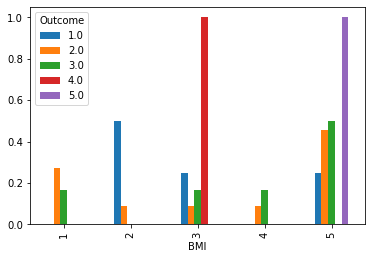

In [33]:
pd.crosstab(selected_rows0["BMI"], selected_rows0["Outcome"], normalize=1).plot(kind="bar")

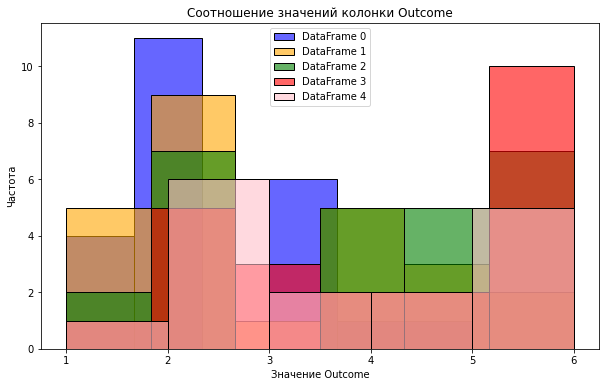

In [29]:
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt


dataframes = [selected_rows0, selected_rows1, selected_rows2, selected_rows3, selected_rows4] 
labels = ['DataFrame 0', 'DataFrame 1', 'DataFrame 2', 'DataFrame 3', 'DataFrame 4']  
colors = ['blue', 'orange', 'green', 'red', 'pink', 'brown']
plt.figure(figsize=(10, 6))
for df, label, color in zip(dataframes, labels, colors):
    sns.histplot(data=df, x='Outcome', label=label, alpha=0.6, color=color)

plt.title('Соотношение значений колонки Outcome')
plt.xlabel('Значение Outcome')
plt.ylabel('Частота')
plt.legend()
plt.show()


In [49]:
donors_clustered

,Unnamed: 0,Age,Sex,BMI,Death28,Institute,PreExistingHeartDisease,PreExistingLungDisease,PreExistingDiabetes,PreExistingHypertension,Smoking,Requiredvasoactive,Respiratorysupport,SARSCoV2PCR,Outcome,TimeSinceOnset,Source_encoded,Institute_encoded,leiden
0,G05061-Ja005E-PBCa,5.0,1,5,0,Oxford,NaN,NaN,NaN,NaN,0,NaN,4.0,1,6.0,16.0,1,0,2
1,G05064-Ja005E-PBCa,5.0,1,5,0,Oxford,NaN,NaN,NaN,NaN,0,NaN,4.0,1,6.0,14.0,1,0,2
2,G05073-Ja005E-PBCa,4.0,1,5,0,Oxford,NaN,NaN,NaN,NaN,0,NaN,4.0,1,6.0,18.0,1,0,2
3,G05077-Ja005E-PBCa,4.0,0,5,0,Oxford,NaN,NaN,NaN,NaN,0,NaN,4.0,1,6.0,17.0,1,0,3
4,G05078-Ja005E-PBCa,3.0,0,5,0,Oxford,NaN,NaN,NaN,NaN,0,NaN,4.0,1,6.0,10.0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,U00607-Ua005E-PBUa,4.0,0,3,0,St_Georges,NaN,NaN,0.0,0.0,0,1.0,1.0,0,2.0,10.0,5,1,0
134,U00613-Ua005E-PBUa,3.0,1,1,0,St_Georges,NaN,NaN,0.0,0.0,0,1.0,1.0,0,2.0,18.0,5,1,1
135,U00617-Ua005E-PBUa,6.0,0,2,0,St_Georges,NaN,NaN,1.0,0.0,1,1.0,1.0,0,2.0,11.0,5,1,4
136,U00619-Ua005E-PBUa,4.0,0,1,1,St_Georges,NaN,NaN,0.0,0.0,0,1.0,5.0,0,1.0,25.0,5,1,1


### 4. Really important part: Perform leiden clusterization on contrastive learning matrixes 

In [197]:
# Read data from the txt file
with open('unique_categories.txt', 'r') as f:
    lines = f.readlines()

# Remove newline '\n' characters
lines = [line.strip() for line in lines]

# Sort based on the 'Names' column
sorted_df = clin_data.set_index('scRNASeq_sample_ID')
sorted_df = sorted_df.loc[lines]

# Output the sorted DataFrame
sorted_df.to_csv('sorted_df.csv')


In [270]:
# Path to the folder containing files
representations_folder = "Representations"

# Function to process each table
def process_representation_file(file_path, donors_path='sorted_df.csv'):
    donors = pd.read_csv(donors_path)
    # Load the table
    latent_features = pd.read_csv(file_path)
    dist_matrix_array = distance_matrix(latent_features, latent_features)
    dist_matrix = pd.DataFrame(dist_matrix_array)
    # Create an AnnData object based on the distance matrix
    distance_adata = sc.AnnData(dist_matrix)
    
    # Calculate neighbors
    sc.pp.neighbors(distance_adata, use_rep="X", metric="precomputed")
    
    # Perform clustering
    sc.tl.leiden(distance_adata)
    
    # Add clustering results to DataFrame
    #donors['New_Column'] = distance_adata.obs
    donors['New_index'] = [str(x) for x in range(0, 140)]
    donors = donors.set_index('New_index')
    donors_clustered = pd.concat([donors, distance_adata.obs], axis=1)
    
    # List of variables for analysis
    vars_to_analyze = ['Outcome', 'Institute', 'Requiredvasoactive', 'Age', 
                      'Respiratorysupport', 'Smoking', 'Death28', 'SARSCoV2PCR']
    
    # Create DataFrame to record statistics
    results = pd.DataFrame(columns=['File', 'Variable', 'Chi-Square', 'P-value'])
    
    for var in vars_to_analyze:
        # Create a cross-tabulation of proportions
        cross_tab = pd.crosstab(donors_clustered.leiden, donors_clustered[var])

        # Perform chi-square test
        chi2, p_value, dof, expected = stats.chi2_contingency(cross_tab)

        # Check significance
        if p_value < 0.05:
            print(f"Variable: {var}")
            print(f"Chi-Square: {chi2:.2f}")
            print(f"P-value: {p_value:.4f}")
            print("Proportions are statistically significantly different")
            
            # Plot graph
            pd.crosstab(donors_clustered.leiden, donors_clustered[var], normalize=0).plot(kind="bar", stacked=True)
            plt.legend(loc=(1.05, 0))
            plt.show()
        else:
            print(f"Variable: {var}")
            print("Proportions do not differ significantly")
            
        # Add results to DataFrame
        results = results.append({'File': file_path, 'Variable': var, 
                                  'Chi-Square': chi2, 'P-value': p_value}, ignore_index=True)
        
        
    
    return results


,File,Variable,Chi-Square,P-value
0,donors_clustered.csv,Outcome,35.529532,0.017459
1,donors_clustered.csv,Institute,2.383450,0.665620
2,donors_clustered.csv,Requiredvasoactive,1.170439,0.882941
3,donors_clustered.csv,Age,30.483665,0.340478
4,donors_clustered.csv,Respiratorysupport,30.765066,0.014416
5,donors_clustered.csv,Smoking,8.678249,0.370161
6,donors_clustered.csv,Death28,4.662746,0.323684
7,donors_clustered.csv,SARSCoV2PCR,13.145173,0.010588


The same operation for pseudobulk matrix:

In [ ]:

# Function to calculate chi-square and save results
def calculate_chi_square_and_save(file_path, output_table, outcome_var):
    donors_clustered = pd.read_csv(file_path, sep='\t', index_col=0)
    
    # List of variables to analyze
    vars_to_analyze = ['Outcome', 'Institute', 'Requiredvasoactive', 'Age', 
                      'Respiratorysupport', 'Smoking', 'Death28', 'SARSCoV2PCR']
    
    # Creating a DataFrame to store results
    results = []

    for var in vars_to_analyze:
        # Creating a cross-tabulation of proportions
        cross_tab = pd.crosstab(donors_clustered.leiden, donors_clustered[var])

        # Performing the chi-square test
        chi2, p_value, dof, expected = stats.chi2_contingency(cross_tab)

        result = {
            'File': os.path.basename(file_path),
            'Variable': var,
            'Chi-Square': chi2,
            'P-value': p_value
        }
        results.append(result)
    
    # Writing results to the output table
    results_df = pd.DataFrame(results)
    output_table = output_table.append(results_df, ignore_index=True)
    
    return output_table

# Creating an empty table to store results
chi_square_results = pd.DataFrame(columns=['File', 'Variable', 'Chi-Square', 'P-value'])

# Path to the file for analysis
file_path = "donors_clustered.csv"

# Calling the function to analyze a single file
chi_square_results = calculate_chi_square_and_save(file_path, chi_square_results, "Outcome")

# Displaying the results
chi_square_results


In [272]:
stats_chi = pd.read_csv('chi_square_results.csv')
stats_chi

,File,Variable,Chi-Square,P-value
0,16_11_100_100_clustered.csv,Outcome,30.327100,0.987410
1,16_11_100_100_clustered.csv,Institute,10.641292,0.386139
2,16_11_100_100_clustered.csv,Requiredvasoactive,6.626106,0.760208
3,16_11_100_100_clustered.csv,Age,58.614530,0.832182
4,16_11_100_100_clustered.csv,Respiratorysupport,23.491239,0.982530
...,...,...,...,...
1003,64_5_300_6000_clustered.csv,Age,41.214062,0.505329
1004,64_5_300_6000_clustered.csv,Respiratorysupport,22.082717,0.574330
1005,64_5_300_6000_clustered.csv,Smoking,15.373400,0.221649
1006,64_5_300_6000_clustered.csv,Death28,11.061003,0.086509


In [318]:
outcome_pvalues = stats_chi.loc[stats_chi['Variable'] == 'Outcome', "P-value"]

In [323]:
best_model_index = outcome_pvalues.index[outcome_pvalues.argmin()]
best_model_index

1008

In [343]:
outcome_pvalues[outcome_pvalues != outcome_pvalues.min()].sort_values()

968    0.079464
224    0.092532
712    0.093106
752    0.114399
112    0.137492
         ...   
576    0.972451
816    0.976526
632    0.978657
872    0.983954
0      0.987410
Name: P-value, Length: 126, dtype: float64

Find the best model by Outcome

In [344]:
stats_chi.loc[968]

File          64_5_300_1000_clustered.csv
Variable                          Outcome
Chi-Square                      35.504384
P-value                          0.079464
Name: 968, dtype: object

Find the worst model by Outcome

In [348]:
stats_chi.loc[stats_chi['File'] == '64_5_300_1000_clustered.csv']

,File,Variable,Chi-Square,P-value
968,64_5_300_1000_clustered.csv,Outcome,35.504384,0.079464
969,64_5_300_1000_clustered.csv,Institute,13.793253,0.016977
970,64_5_300_1000_clustered.csv,Requiredvasoactive,6.144466,0.292415
971,64_5_300_1000_clustered.csv,Age,34.805125,0.477476
972,64_5_300_1000_clustered.csv,Respiratorysupport,32.123921,0.041996
973,64_5_300_1000_clustered.csv,Smoking,14.492983,0.151669
974,64_5_300_1000_clustered.csv,Death28,15.814850,0.007393
975,64_5_300_1000_clustered.csv,SARSCoV2PCR,16.239811,0.006192


Check other good models

In [325]:
worst_model_index = outcome_pvalues.index[outcome_pvalues.argmax()]
worst_model_index

0

In [326]:
stats_chi.loc[worst_model_index]

File          16_11_100_100_clustered.csv
Variable                          Outcome
Chi-Square                        30.3271
P-value                           0.98741
Name: 0, dtype: object

In [327]:
stats_chi

,File,Variable,Chi-Square,P-value
0,16_11_100_100_clustered.csv,Outcome,30.327100,0.987410
1,16_11_100_100_clustered.csv,Institute,10.641292,0.386139
2,16_11_100_100_clustered.csv,Requiredvasoactive,6.626106,0.760208
3,16_11_100_100_clustered.csv,Age,58.614530,0.832182
4,16_11_100_100_clustered.csv,Respiratorysupport,23.491239,0.982530
...,...,...,...,...
1035,donors_clustered.csv,Age,30.483665,0.340478
1036,donors_clustered.csv,Respiratorysupport,30.765066,0.014416
1037,donors_clustered.csv,Smoking,8.678249,0.370161
1038,donors_clustered.csv,Death28,4.662746,0.323684


In [317]:
stats_chi.loc[stats_chi['File'] == '16_3_100_500_clustered.csv']


,File,Variable,Chi-Square,P-value
120,16_3_100_500_clustered.csv,Outcome,32.043111,0.611614
121,16_3_100_500_clustered.csv,Institute,9.791145,0.200721
122,16_3_100_500_clustered.csv,Requiredvasoactive,8.844697,0.263999
123,16_3_100_500_clustered.csv,Age,39.680745,0.826436
124,16_3_100_500_clustered.csv,Respiratorysupport,22.766511,0.744635
125,16_3_100_500_clustered.csv,Smoking,17.914698,0.210694
126,16_3_100_500_clustered.csv,Death28,8.749056,0.271178
127,16_3_100_500_clustered.csv,SARSCoV2PCR,11.764544,0.108573


In [276]:
stats_chi = stats_chi.append(chi_square_results)
stats_chi.max()

File          donors_clustered.csv
Variable                   Smoking
Chi-Square               82.429123
P-value                   0.999128
dtype: object

In [277]:
stats_chi.describe()

,Chi-Square,P-value
count,1040.000000,1040.000000
mean,18.751923,0.462578
std,14.351859,0.298150
min,0.208964,0.000039
25%,8.054869,0.200968
50%,14.109593,0.439220
75%,27.409453,0.723403
max,82.429123,0.999128


In [292]:
# Grouping results by variables and finding the maximum and minimum chi-square
max_chi_square = chi_square_results.groupby('Variable')['Chi-Square'].max()
min_chi_square = chi_square_results.groupby('Variable')['Chi-Square'].min()

print("Максимальное значение хи-квадрата по переменным:")
print(max_chi_square)

print("\nМинимальное значение хи-квадрата по переменным:")
print(min_chi_square)

Максимальное значение хи-квадрата по переменным:
Variable
Age                   30.483665
Death28                4.662746
Institute              2.383450
Outcome               35.529532
Requiredvasoactive     1.170439
Respiratorysupport    30.765066
SARSCoV2PCR           13.145173
Smoking                8.678249
Name: Chi-Square, dtype: float64

Минимальное значение хи-квадрата по переменным:
Variable
Age                   30.483665
Death28                4.662746
Institute              2.383450
Outcome               35.529532
Requiredvasoactive     1.170439
Respiratorysupport    30.765066
SARSCoV2PCR           13.145173
Smoking                8.678249
Name: Chi-Square, dtype: float64


In [284]:
chi_square_results_sorted = stats_chi.sort_values(by='Chi-Square')
chi_square_results_sorted

,File,Variable,Chi-Square,P-value
954,64_5_10_500_clustered.csv,Requiredvasoactive,0.208964,0.999014
858,64_3_300_100_clustered.csv,Requiredvasoactive,0.933643,0.988003
543,32_3_300_500_clustered.csv,SARSCoV2PCR,1.049956,0.983647
2,donors_clustered.csv,Requiredvasoactive,1.170439,0.882941
2,donors_clustered.csv,Requiredvasoactive,1.170439,0.882941
...,...,...,...,...
235,16_5_100_3000_clustered.csv,Age,66.117650,0.051915
283,16_5_10_500_clustered.csv,Age,69.242299,0.110052
379,32_11_10_3000_clustered.csv,Age,72.972950,0.182952
595,32_5_10_1000_clustered.csv,Age,77.328830,0.031027


In [254]:
stats["File"].value_counts()

16_11_100_100_clustered.csv    8
32_5_300_1000_clustered.csv    8
64_11_300_100_clustered.csv    8
64_11_10_6000_clustered.csv    8
64_11_10_500_clustered.csv     8
                              ..
16_5_300_1000_clustered.csv    8
16_5_10_6000_clustered.csv     8
16_5_10_500_clustered.csv      8
16_5_10_3000_clustered.csv     8
64_5_300_6000_clustered.csv    8
Name: File, Length: 126, dtype: int64

<AxesSubplot:xlabel='Variable', ylabel='P-value'>

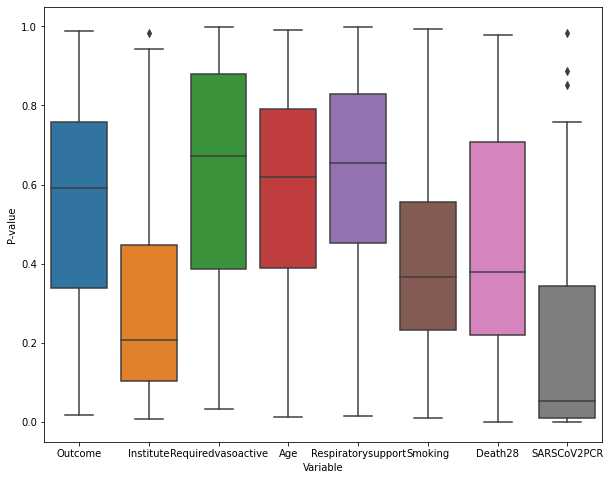

In [291]:
plt.figure(figsize=(10,8))
sns.boxplot(x=stats_chi["Variable"], y=stats_chi["P-value"])